In [ ]:
import numpy as np
from scipy.optimize import least_squares

from matplotlib import pyplot as plt
import pandas as pd

from marketdata import MarketData
from heston import HestonModel
from blackscholes import bs_call, __implied_volatility

import matplotlib.pyplot as plt


from ipywidgets import interact, FloatSlider




Now volatility is a stochastic process that deviates back to its mean over time.

this fits into the usual Brownian motion framework

$$dS_t=\mu S_t dt+\sqrt{\nu}_t S_t dW_t^{S}$$

$$d\nu_t=\kappa(\theta-\nu_t)dt+\xi\sqrt{\nu_t}dW_t^{\nu}.$$

where $W_t^S,W_t^{\nu}$ 
are continuous random walks with correlation 
$\rho$. 
We can solve these equations simultaneously 
in the risk-neutral model under some assumptions such 
as constant correlation (covariance), 
constant "volatility of volatility" or 
randomness i.e. second variation, and 
constant rate of reversion, an expected variance. 
In practice, this is subject to boundary conditions.

$\nu_0$ is the initial variance

$\theta $ is the long variance (expected value of volatility as $t \to \infty$)

$\rho $ is the correlation

$\kappa $ is the rate of reversion

$\xi $ is the volatility of volatility .

this model was prefered to a linear differential equation for the volatility (Ornstein-Uhlenbeck) because the volatility is never negative. In particular, the solution for the Heston model is strictly positive subject to the relation that 
$$2\kappa \theta>\xi^2 $$


Here's the LaTeX converted to Markdown format for Jupyter:
markdownIn the pricing of a European call option, one derives from put-call parity the familiar formula

$$C(\theta,K,T)= e^{-rT}\mathbb E[(S_T-K)\cdot \mathbb 1_{S_T \geq K}(S_T)],$$

where $\theta=[v_0,\overline{v},\rho,\kappa,\sigma]^T$. Using the linearity of expectation, one can re-express this as

$$ C(\theta,K,T)=S_0P_1-e^{rT}KP_2,$$

where $P_2$ is the probability of $S_T$ finishing in the money, and $P_1$ is a random variable weighted by this probability (it is the probability with respect to the numeraire given by $S_T$ rather than cash.)

By using a Fourier transform, [Heston](https://www.ma.imperial.ac.uk/~ajacquie/IC_Num_Methods/IC_Num_Methods_Docs/Literature/Heston.pdf) derived closed form solutions for $P_1$ and $P_2$ in terms of the characteristic function $\phi(\theta,u,T)$:
$$
\begin{align*}
P_1&=\frac{1}{2}+\frac{1}{\pi}\int_{0}^\infty \mathrm{Re}\left(\frac{e^{-iu \mathrm{log} K}}{uiF} \phi(\theta,u-i,T) \right)du \\
P_2&=\frac{1}{2}+\frac{1}{\pi}\int_{0}^\infty \mathrm{Re}\left(\frac{e^{-iu \mathrm{log} K}}{uiF} \phi(\theta,u,T) \right) du
\end{align*}
$$
where $F:=S_0e^{rT}$ is the forward price of the underlying stock $S_0$. There were previously several issues  with calibrating the parameter vector $\theta$,
due to taking consistent branches of the complex logarithm in the expression for $\phi$. 

However, [Cui-Rollin-Germano](https://arxiv.org/abs/1511.08718) provided 
a new expression for $\phi$ that was analytically tractable enough to compute the gradient of $\phi$ with respect to each parameter, and thus efficiently compute the gradient
for $C$ efficiently via least squares. That is, we calibrate the model, by taking market data $C^{*}(K_i,T_i)$ for a call option with strike $K_i$ and maturity $T_i$, and minimizing

$$
\begin{align*}
    \mathrm{min}_{\theta \in \mathbb R^m}\frac{1}{2}r^T(\theta)r\theta,
\end{align*}
$$
where $r_i(\theta):=C(\theta,K_i,T_i)-C^{*}(K_i,T_i)$ are residual vectors. In this case, we have that

$$
\begin{align*} 
    \nabla f&= Jr\\
    \nabla \nabla^T f&=JJ^T+\sum_{i=1}^n r_iH(r_i)
\end{align*}
$$

so we can employ a root finding algorithm to minimize our objective function, so long as we have an expression for the gradient.

we provide all the relevant formulas in the ```HestonModel``` class, notably the method ```_gradient```, which features vectorized numerical integration via ```Scipy.quad_vec```.


In [2]:
""" MarketData class is a wrapper for
    spot_price: float  # S0
    risk_free_rate: float  # r
    strikes: np.ndarray  # K_i
    maturities: np.ndarray  # T_i
    market_prices: np.ndarray  # C^*

for simplicity, we fix $r$ throughout at .04


IMPORTANT: 

in the least_squares method, one can 
enable Levenberg-Marquadt by setting method='lm' in 
scipy.least_squares, but this is not compatible with the boundary
conditions for our parameters.

Furthermore, one can enforce Feller conditions, but since
they are not linear, one needs to use the more general scipy.minimize
method which is much less efficient.

"""
# A naive initial guess to begin calibration
IG = HestonModel(v0=0.04, v_bar=0.04, rho=-0.2, kappa=1.0, sigma=0.2)
# boundaries on admissible values for all parameters
BD = [(0.001, 1.0), (0.001, 1.0), (-0.999, 0.999), (0.01, 10.0), (0.01, 2.0)]


def price_call(model: HestonModel, md: MarketData):
    S0 = md.spot_price
    r = md.risk_free_rate
    K = md.strikes
    T = md.maturities
    return model._heston_price_call(S0, r, K, T)


# could not use 'lm' method as suggested in the original paper as we have bounds on our variables.
# One can instead remove BD and enable the method='lm' option in scipy.


def calibrate(md: MarketData, bounds=BD, guess: HestonModel = IG) -> HestonModel:
    # Convert initial guess to array
    x0 = np.array([guess.v0, guess.v_bar, guess.rho, guess.kappa, guess.sigma])
    S0 = md.spot_price
    r = md.risk_free_rate
    strikes = md.strikes
    maturities = md.maturities
    market_prices = md.market_prices

    def residuals_wrapper(x):
        theta = HestonModel(v0=x[0], v_bar=x[1], rho=x[2], kappa=x[3], sigma=x[4])
        model_prices = theta._heston_price_call(S0, r, strikes, maturities)
        return model_prices - market_prices  # Vector of residuals

    def jac_wrapper(x):
        theta = HestonModel(v0=x[0], v_bar=x[1], rho=x[2], kappa=x[3], sigma=x[4])
        # Just return the Jacobian, not J^T @ residuals
        return theta._gradient(S0, r, strikes, maturities).T

    # Convert bounds
    lower_bounds = np.array([0.001, 0.001, -0.999, 0.01, 0.01])
    upper_bounds = np.array([1.0, 1.0, 0.999, 10.0, 2.0])

    result = least_squares(
        residuals_wrapper, x0=x0, jac=jac_wrapper, bounds=(lower_bounds, upper_bounds)
    )

    # Return as HestonModel object
    return HestonModel(
        v0=result.x[0],
        v_bar=result.x[1],
        rho=result.x[2],
        kappa=result.x[3],
        sigma=result.x[4],
    )

We can improve our initial guess quickly in several ways. The most obvious is setting the initial volatility $v_0$ in a more intelligent manner.

There are a few ways to do this, but we follow the observations made by Gatheral in 
["The Volatility Surface." (pg 34-35)](http://www.hk.free.fr/Docs/The%20Volatility%20Surface%20-%20A%20Practitioner's%20Guide%20%5BJim%20Gatheral%5D.pdf)


First, here are some helpful heuristics: $v_0$ controls  the position of volatility smile, $\rho$ controls the skewness, 
$\kappa$ and $\xi$ the convexity, while $\kappa(\theta-v_0)$ controls the term structure for implied volatility.
For ATM options with short maturity $T \to 0$, the implied volatility $\sigma_{BS}$ approximates to $\sqrt{v_0}$ 
(there's no room to smile and the stochastic part in the Heston Model is not so relevant.)

For sufficiently short $T$, the option price behaves like:
$$
\begin{align*}
C(S_0, K, T) \simeq C_{BS}(S_0, K, T; \sigma = \sqrt{v_0})
\end{align*}
$$
where $C_{BS}$ is the Black-Scholes price with constant volatility $\sqrt{v_0}$.

For small $T$, we can approximate:
$$
\begin{align*}
\int_0^T v_s ds \approx v_0 T + O(T^{3/2})
\end{align*}
$$

meaning that the total variance $[0,T]$ is approximately $v_0$, making the option price:
$$
\begin{align*}
C \approx C_{BS}(S_0, K, T; \sqrt{v_0})
\end{align*}
$$

This leads us to  initialize $v_0$ at the Black-Scholes implied volatility. We implement this in the ```MarketData``` class via two functions that filter to short term and atm options.

For implied volatility, we use two methods ```__jackel_initial_guess``` which is a simplification for initializing options pricing by [Peter Jackel](http://www.jaeckel.org/ImpliedNormalVolatility.pdf).
Here, we distinguish between options ATM, deep ITM, and then all others which are based on heuristics. For at the money, we leave the heuristic solution

$$
\begin{align*}
    \sigma_{BS} \cong \sqrt{\frac{2\pi}{T}} \cdot \frac{c}{F}
\end{align*}
$$
where $T$ is time to maturity and $c$,$F$ are the forward prices of the observed market price $C^*$ and spot price $S_0$, respectively.

For deep in the money, we just guess $.4$, and otherwise, follow his algorithm.

For ```__implied_volatility``` we use a vectorized Newton's Algorithm on a Black-Scholes call price (otherwise one can use ```Scipy``` methods, but are forced to loop through the market data.)

Finally, we estimate $v_0$ by first filtering near at the money stock data via two methods ```short_term``` and ```atm```. All of this is packaged together in the
method ```initialize_volatility``` for a ```MarketData``` object.


In [3]:
# dimension reduction by initializing v0 to "instantaneous volatility" by approximating with implied volatility very short term atm options.


def calibrate_iv(md: MarketData, bounds=BD, guess: HestonModel = IG) -> HestonModel:
    # Convert initial guess to array
    iv = float(md.initial_volatility())
    x0 = np.array([guess.v_bar, guess.rho, guess.kappa, guess.sigma])
    S0 = md.spot_price
    r = md.risk_free_rate
    strikes = md.strikes
    maturities = md.maturities
    market_prices = md.market_prices

    # Residuals function
    def residuals_wrapper(x):
        theta = HestonModel(v0=iv, v_bar=x[0], rho=x[1], kappa=x[2], sigma=x[3])
        model_prices = theta._heston_price_call(S0, r, strikes, maturities)
        return model_prices - market_prices  # Vector of residuals

    # Jacobian of residuals
    def jac_wrapper(x):
        theta = HestonModel(v0=iv, v_bar=x[0], rho=x[1], kappa=x[2], sigma=x[3])
        # Just return the Jacobian, not J^T @ residuals
        return theta._gradient(S0, r, strikes, maturities)[1:, :].T

    # Convert bounds
    lower_bounds = np.array([0.001, -0.999, 0.01, 0.01])
    upper_bounds = np.array([1.0, 0.999, 10.0, 2.0])

    result = least_squares(
        residuals_wrapper, x0=x0, jac=jac_wrapper, bounds=(lower_bounds, upper_bounds)
    )

    # Return as HestonModel object
    return HestonModel(
        v0=iv, v_bar=result.x[0], rho=result.x[1], kappa=result.x[2], sigma=result.x[3]
    )

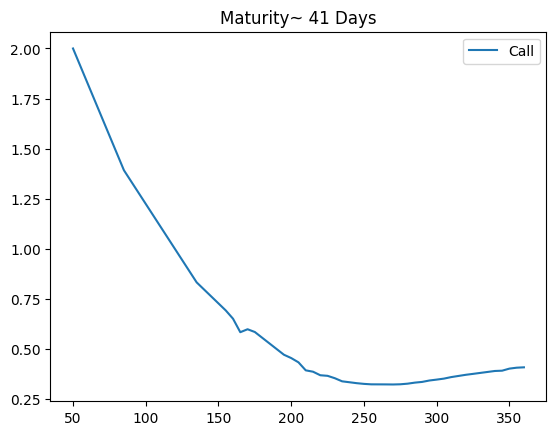

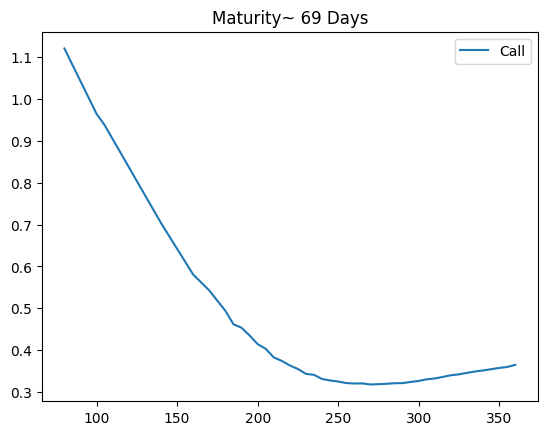

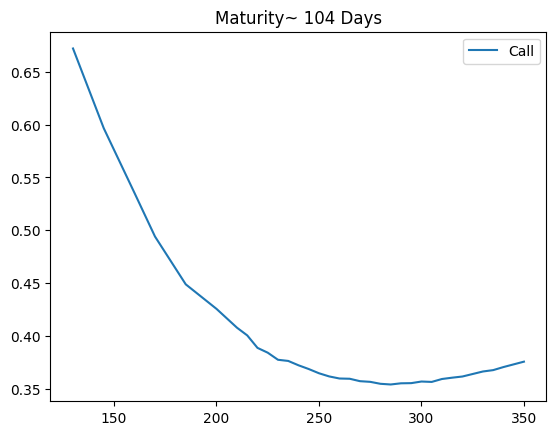

In [4]:
"""example MarketData usage to graph some volatility smiles"""


amazon_data:MarketData = MarketData.from_yahoo_finance("AMZN")
unique_maturities = np.unique(amazon_data.maturities)
short_mask = (unique_maturities < 0.3) & (unique_maturities > 0.1)
some_maturities = unique_maturities[short_mask]
for date in some_maturities:
    date_mask = amazon_data.maturities == date
    market_prices = amazon_data.market_prices[date_mask]
    strikes = amazon_data.strikes[date_mask]

    volatilities = (amazon_data.implied_volatility())[date_mask]

    plt.plot(strikes, volatilities, label="Call")

    plt.title(f"Maturity~ {int(date * 365)} Days")
    plt.legend()
    plt.show()

In [5]:
'''we also use a from_yahoo_finance method to quickly initialize data as a MarketData object'''

tickers = ["MSFT", "AMZN", "GOOGL", "SPY", "AAPL", "TSLA"]
market_data: dict[str, MarketData] = {}

for ticker in tickers:
    market_data[ticker] = MarketData.from_yahoo_finance(ticker)


In [6]:
# we exclude severe outliers from data. We grab data stocks nearby with strikes and maturities within 5% and 2%,
# and if outside 3 times the median absolute deviation for nearby points, we exclude

cleaned_data = {}

for ticker in tickers:
    cleaned_data[ticker] = market_data[ticker].remove_outliers()

    print(
        f"{market_data[ticker].maturities.size - cleaned_data[ticker].maturities.size} points removed from {ticker} data"
    )


5 points removed from MSFT data
1 points removed from AMZN data
4 points removed from GOOGL data
12 points removed from SPY data
6 points removed from AAPL data
9 points removed from TSLA data


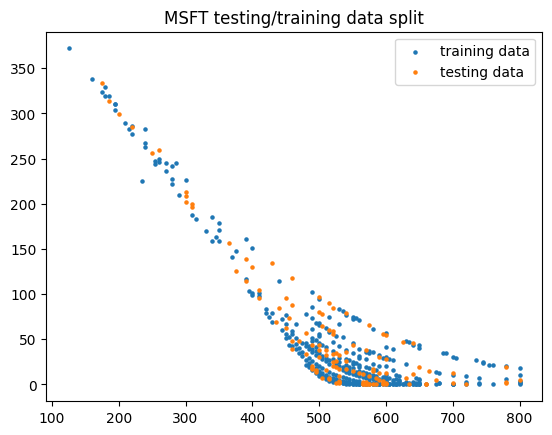

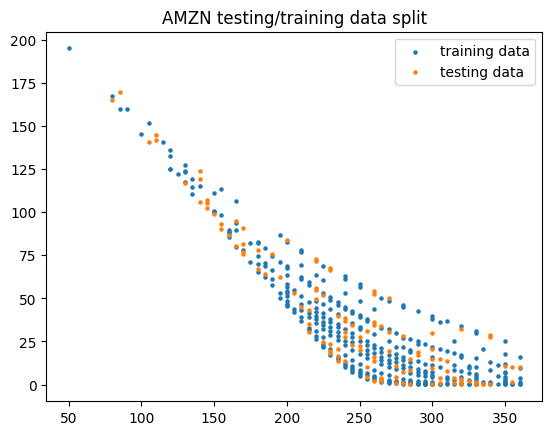

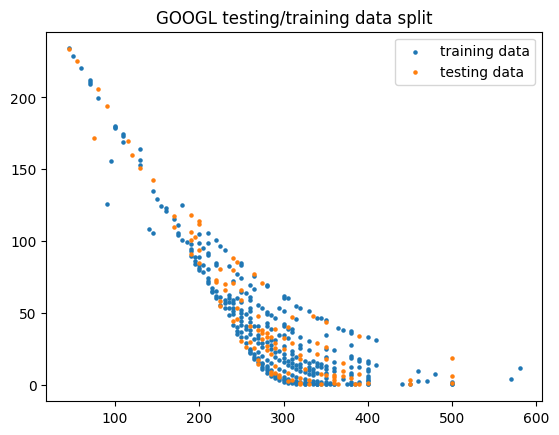

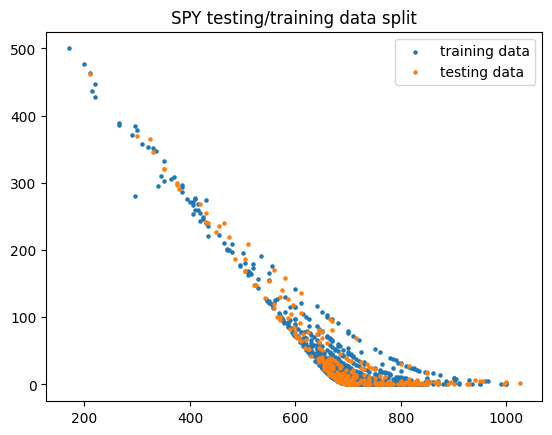

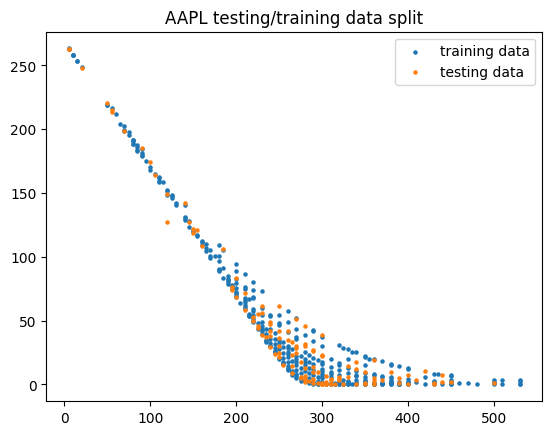

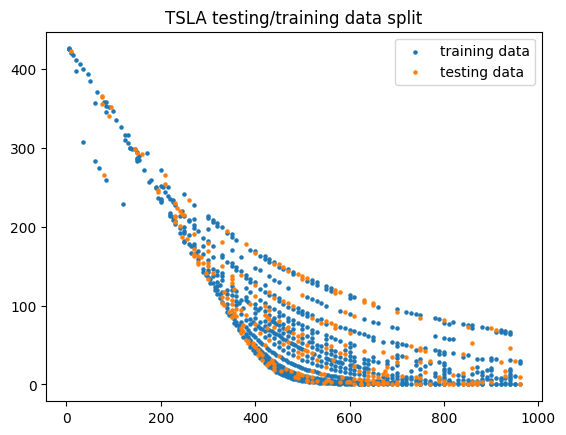

In [7]:
# split into training, testing data. we do a 3/4 split, leaving 25% for validation
market_training_data = {}
market_testing_data = {}
for ticker in tickers:
    market_training_data[ticker], market_testing_data[ticker] = cleaned_data[
        ticker
    ].testing()
    ticker_testing = market_testing_data[ticker]

    plt.scatter(
        market_training_data[ticker].strikes,
        market_training_data[ticker].market_prices,
        label="training data",
        s=5,
    )
    plt.scatter(
        market_testing_data[ticker].strikes,
        market_testing_data[ticker].market_prices,
        label="testing data",
        s=5,
    )

    plt.legend()
    plt.title(f"{ticker} testing/training data split")
    plt.show()


In [8]:
#We do a usual gradient-based optimization, but compare it to one in which we leave the initial_volatility fixed (calibrated to short term atm IV)
models = {}
models_iv = {}
for ticker in tickers:
    models[ticker] = calibrate(market_training_data[ticker])
    models_iv[ticker] = calibrate_iv(market_training_data[ticker])


/Users/bubba/Documents/python notebooks/finance bootcamp /heston_project/heston.py:37: UserWarning: Feller condition not satisfied
  warnings.warn('Feller condition not satisfied')


In [9]:
fixed = []
varied = []

for ticker in tickers:
    model_prices = price_call(models[ticker], market_testing_data[ticker])
    model_iv_prices = price_call(models_iv[ticker], market_testing_data[ticker])
    prices = market_testing_data[ticker].market_prices
    fixed.append(
        sum((model_iv_prices - prices) ** 2)
        / market_testing_data[ticker].market_prices.size
    )
    varied.append(
        sum((model_prices - prices) ** 2) / market_testing_data[ticker].market_prices.size
    )


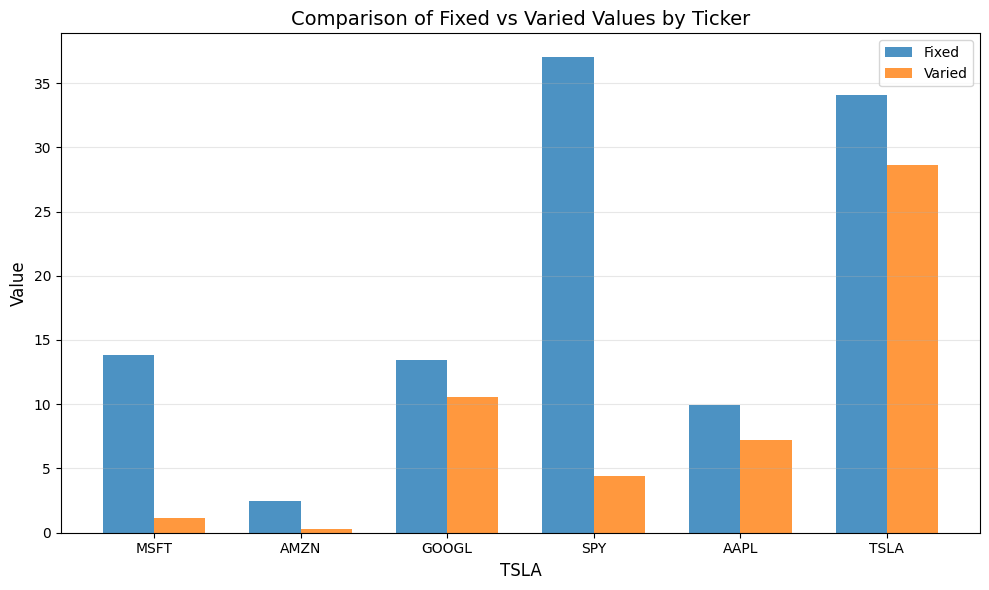

In [10]:


x = np.arange(len(tickers))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width / 2, fixed, width, label="Fixed", alpha=0.8)
bars2 = ax.bar(x + width / 2, varied, width, label="Varied", alpha=0.8)

# Customize the plot
ax.set_xlabel(ticker, fontsize=12)
ax.set_ylabel("Value", fontsize=12)
ax.set_title("Comparison of Fixed vs Varied Values by Ticker", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(tickers)
ax.legend()
ax.grid(axis="y", alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()


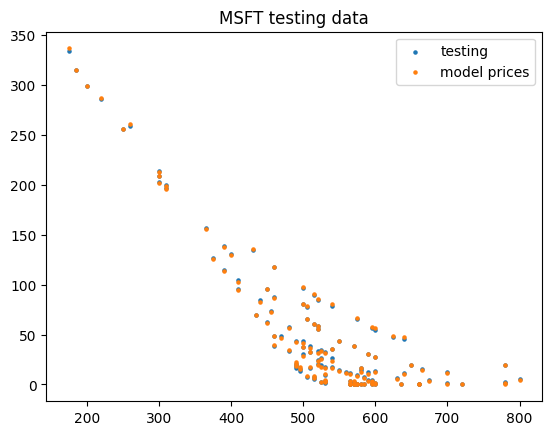

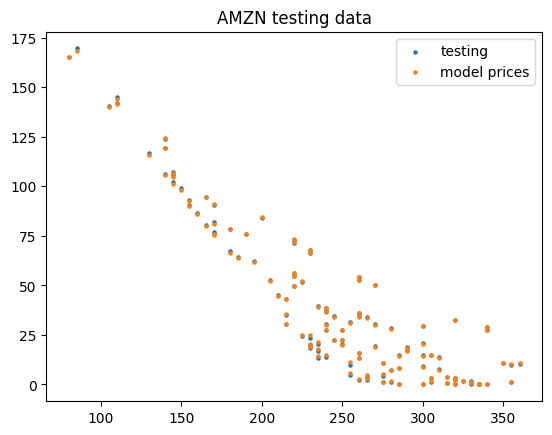

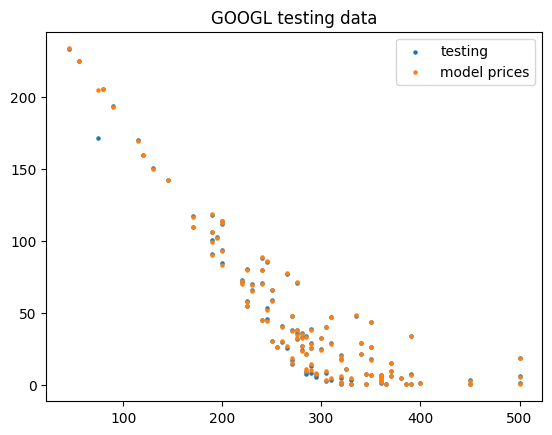

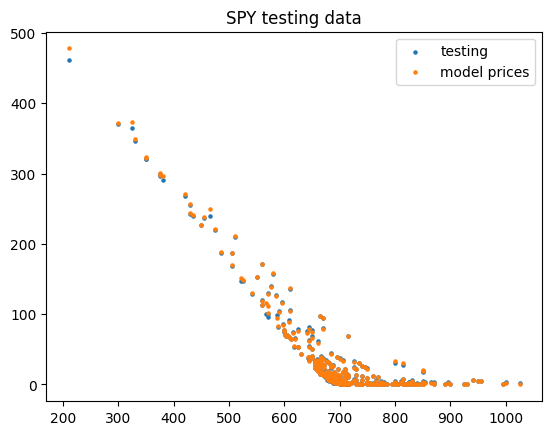

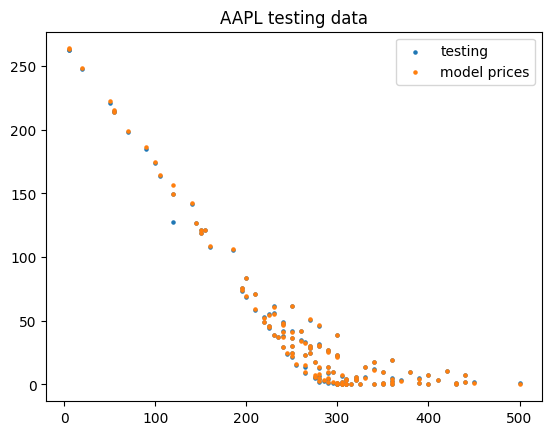

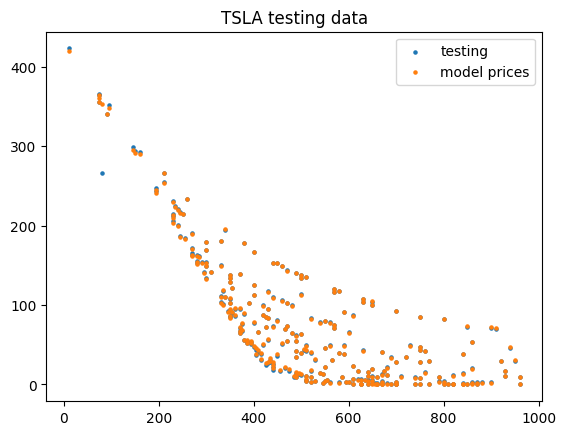

"\n    training_prices=price_call(models[ticker],ticker_training)\n    plt.scatter(ticker_training.strikes, ticker_training.market_prices, label = 'training',s=5)\n    plt.scatter(ticker_training.strikes,training_prices,label='model prices',s=5)\n    plt.legend()\n    plt.show()\n\n"

In [11]:
for ticker in tickers:
    ticker_testing = market_testing_data[ticker]

    testing_prices = price_call(models[ticker], ticker_testing)
    plt.scatter(
        ticker_testing.strikes, ticker_testing.market_prices, label="testing", s=5
    )
    plt.scatter(ticker_testing.strikes, testing_prices, label="model prices", s=5)

    plt.legend()
    plt.title(f"{ticker} testing data")
    plt.show()
"""
    training_prices=price_call(models[ticker],ticker_training)
    plt.scatter(ticker_training.strikes, ticker_training.market_prices, label = 'training',s=5)
    plt.scatter(ticker_training.strikes,training_prices,label='model prices',s=5)
    plt.legend()
    plt.show()

"""


In [12]:
#We can take a look at points on which the data is severely wrong

for ticker in tickers:
    ticker_testing = market_testing_data[ticker]
    model_prices = price_call(models[ticker], ticker_testing)
    prices = ticker_testing.market_prices
    # square difference more than 10% of market price
    are_different = abs(model_prices - prices) > 10
    print(f"{ticker} Data For Error  >10%")
    print(ticker_testing.market_prices[are_different])
    print(model_prices[are_different])
    if any(are_different):
        print(f"{ticker} model parameters: {models[ticker]}")


MSFT Data For Error  >10%
[]
[]
AMZN Data For Error  >10%
[]
[]
GOOGL Data For Error  >10%
[171.575]
[204.90711733]
GOOGL model parameters: v0=0.14683485544290142 v_bar=0.8923526235435647 rho=-0.23531576697590195 kappa=0.010000001514542039 sigma=0.26555656496686403
SPY Data For Error  >10%
[ 95.63 462.09  99.95]
[111.77552763 478.00099941 116.37667609]
SPY model parameters: v0=0.025004513718539276 v_bar=0.03078258445487609 rho=-0.8197714146674011 kappa=1.8632774037355502 sigma=0.31687705340538064
AAPL Data For Error  >10%
[127.625]
[156.67763269]
AAPL model parameters: v0=0.0709992372857091 v_bar=0.08833512245389287 rho=-0.37749944892524484 kappa=0.9634164658911726 sigma=0.4026320154067719
TSLA Data For Error  >10%
[266.325]
[352.64161811]
TSLA model parameters: v0=0.3763397417852115 v_bar=0.5733310522868648 rho=-0.03710198330128262 kappa=0.4733989167787319 sigma=1.071334065612061


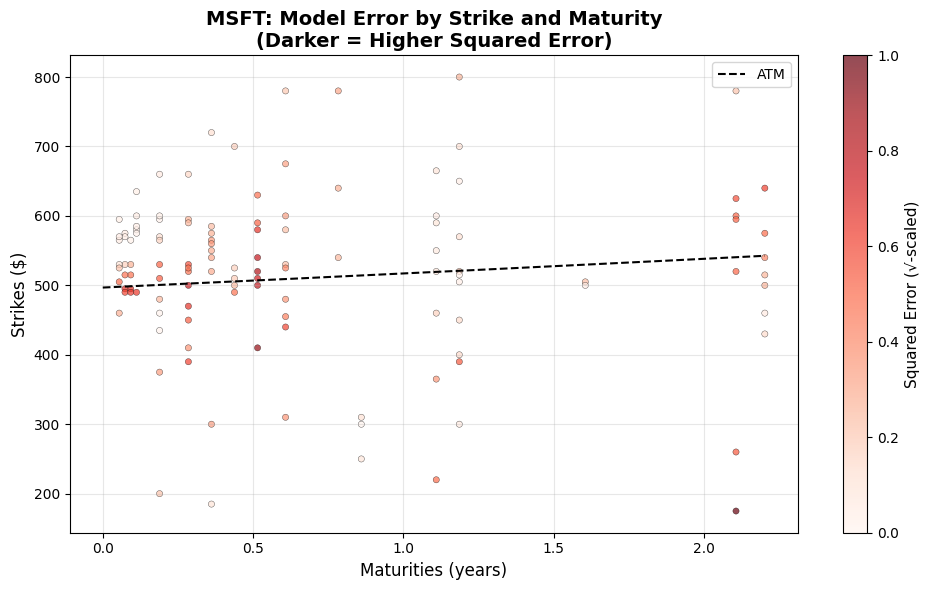

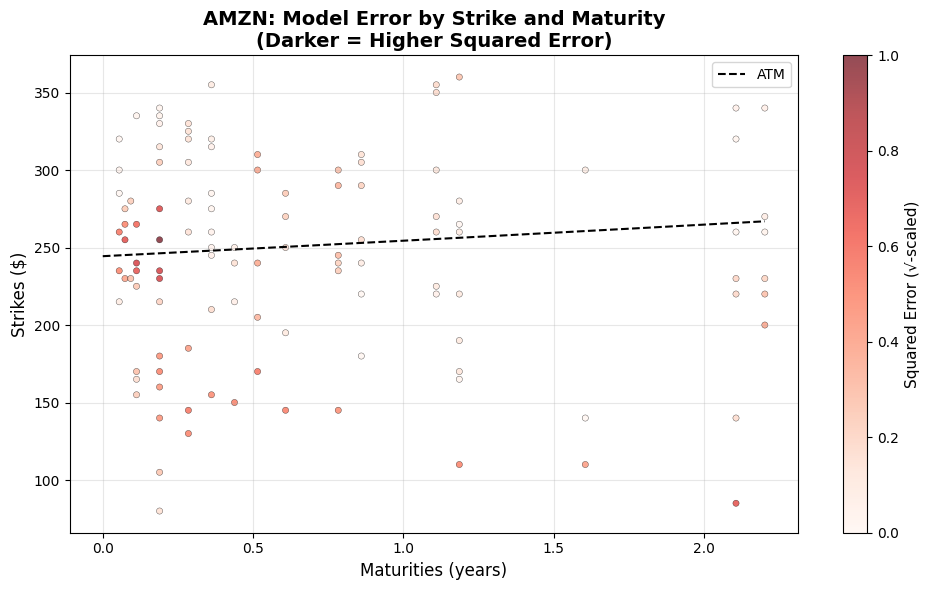

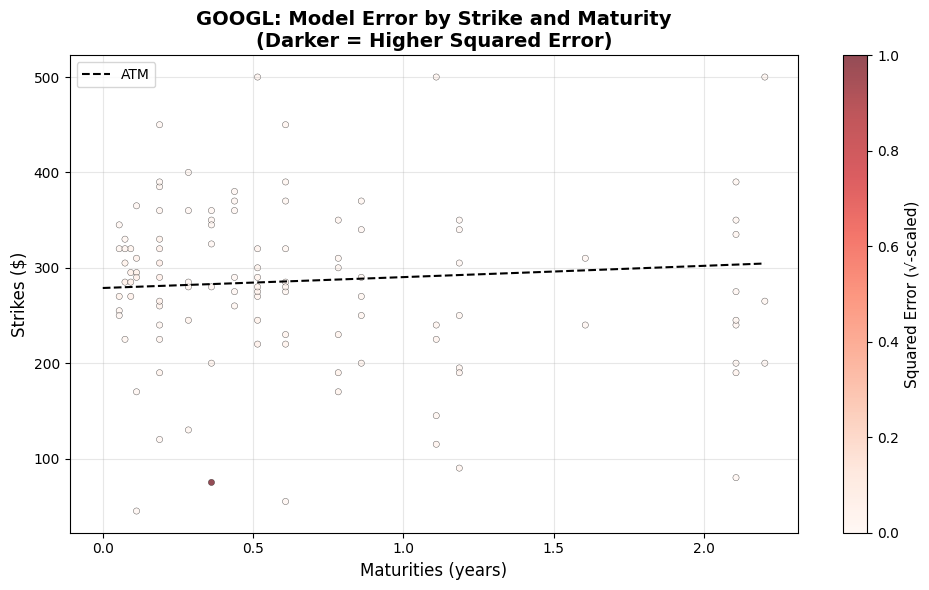

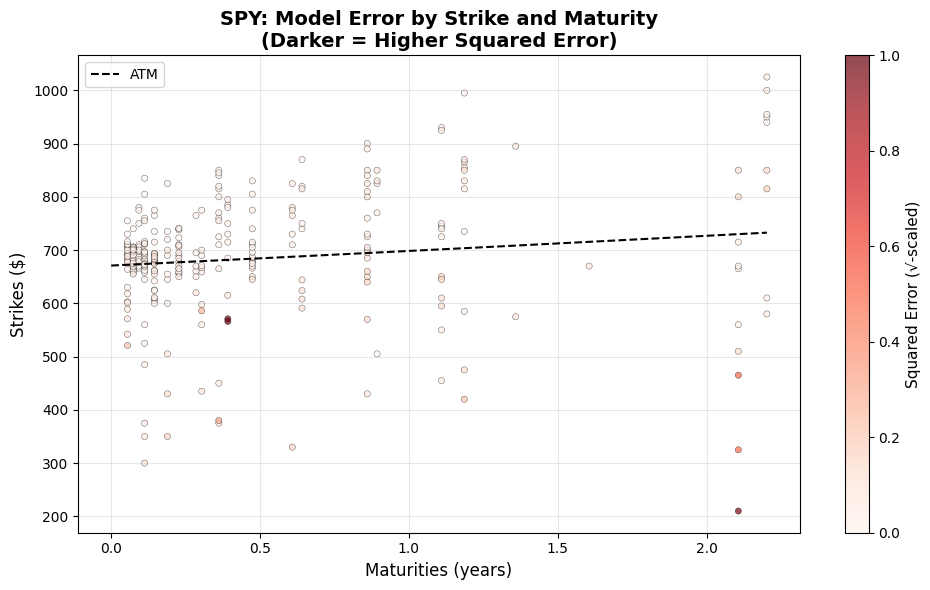

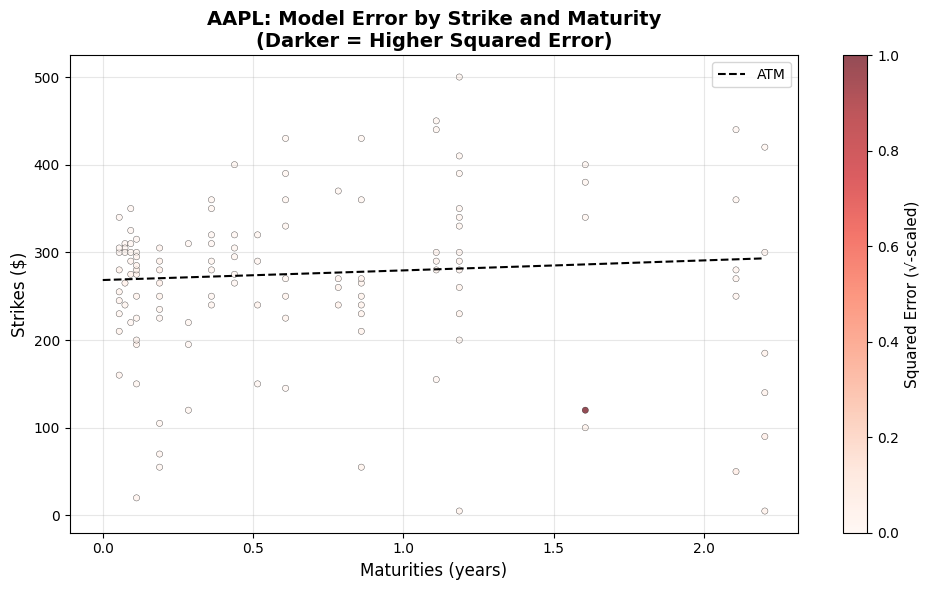

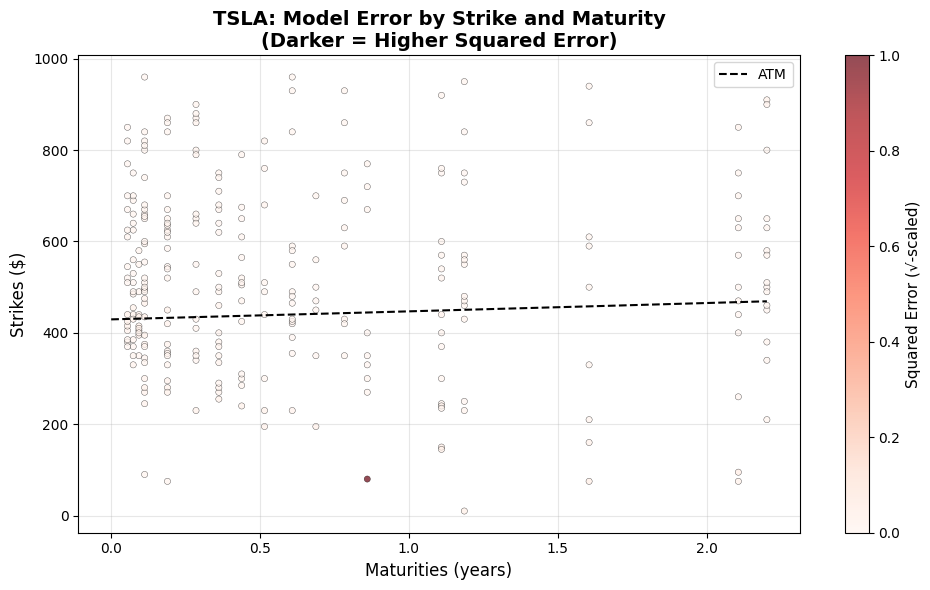

In [13]:
#We can check to see if there are patterns in where the square error is particularly bad

for ticker in tickers:
    ticker_testing = market_testing_data[ticker]
    model_prices = price_call(models[ticker], ticker_testing)
    prices = ticker_testing.market_prices

    # Calculate squared errors
    squared_errors = (model_prices - prices) ** 2

    # Apply square root transformation to make red appear faster
    if np.max(squared_errors) > 0:
        normalized_errors = np.sqrt(squared_errors / np.max(squared_errors))
    else:
        normalized_errors = squared_errors

    # Plot ATM line
    max_maturity = np.max(ticker_testing.maturities)
    x_function = np.linspace(0, max_maturity, 150)
    r = ticker_testing.risk_free_rate
    y_function = np.exp(r * x_function) * ticker_testing.spot_price

    # Create scatter plot with faster red transition
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(
        ticker_testing.maturities,
        ticker_testing.strikes,
        c=normalized_errors,
        cmap="Reds",
        s=20,
        alpha=0.7,
        vmin=0,
        vmax=1,  # Explicitly set color range
        edgecolors="black",
        linewidth=0.3,
    )

    ax.plot(
        x_function, y_function, color="black", linestyle="--", linewidth=1.5, label="ATM"
    )

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Squared Error (√-scaled)", fontsize=11)

    ax.set_xlabel("Maturities (years)", fontsize=12)
    ax.set_ylabel("Strikes ($)", fontsize=12)
    ax.legend(fontsize=10)
    ax.set_title(
        f"{ticker}: Model Error by Strike and Maturity\n(Darker = Higher Squared Error)",
        fontsize=14,
        fontweight="bold",
    )
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

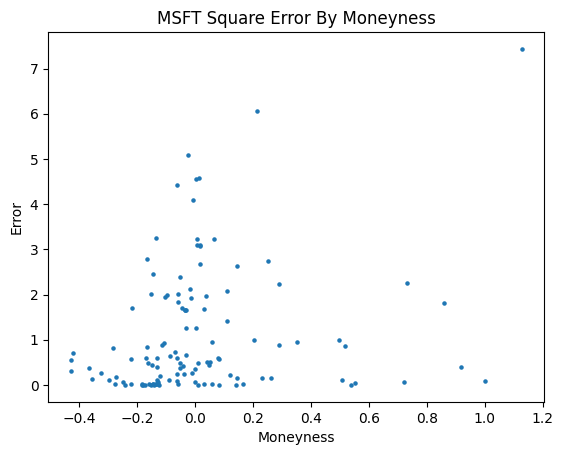

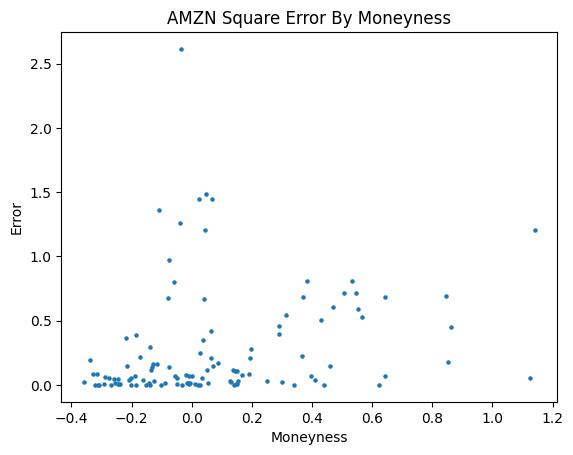

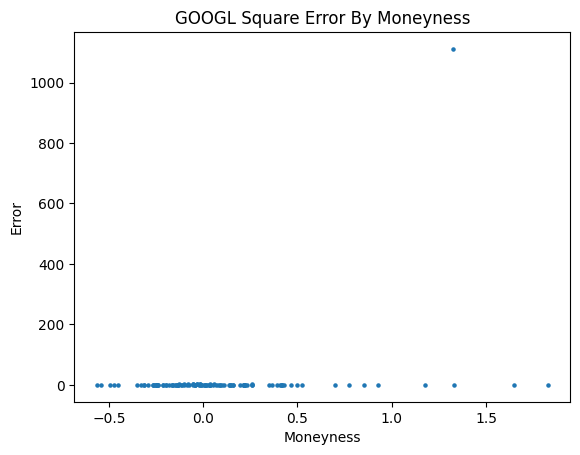

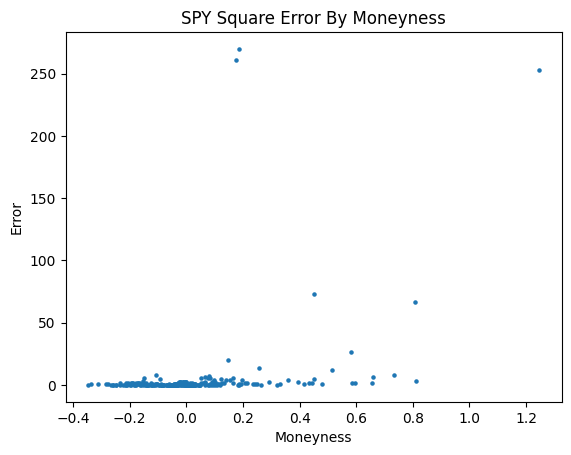

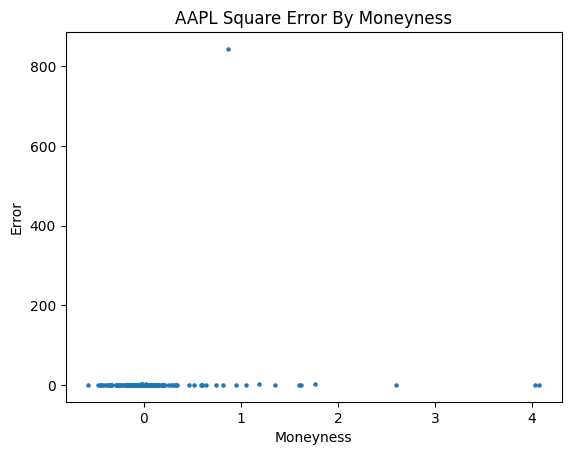

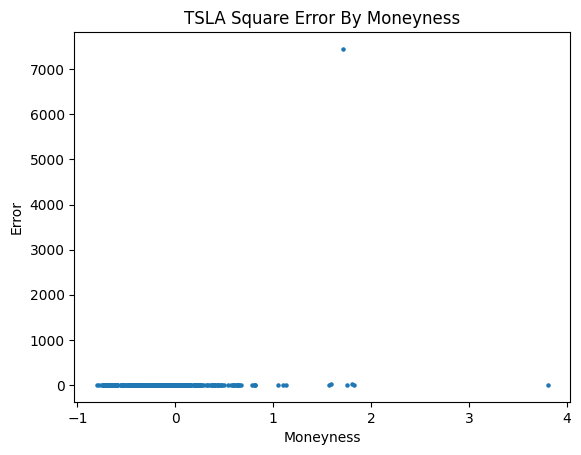

In [14]:
for ticker in tickers:
    ticker_testing = market_testing_data[ticker]
    model_prices = price_call(models[ticker], ticker_testing)
    prices = ticker_testing.market_prices
    # square difference more than 10% of market price
    error = abs(model_prices - prices) ** 2
    are_close = ~are_different
    r = ticker_testing.risk_free_rate
    T = ticker_testing.maturities
    S0 = ticker_testing.spot_price
    K = ticker_testing.strikes
    F = S0 * np.exp(r * T)
    x = np.log(F / K)
    c = prices * np.exp(r * T)

    testing_prices = price_call(models[ticker], ticker_testing)
    plt.scatter(x, error, s=5)

    plt.xlabel("Moneyness")
    plt.ylabel("Error")
    plt.title(f"{ticker} Square Error By Moneyness")
    plt.show()

In [ ]:
#For trading, absolute error is of course relevant as well, and we can check to see where our model failed very hard

def create_interactive_plot(ticker, ticker_testing, model_prices, prices):
    """Create interactive plot with proper closure"""
    abs_errors = np.abs(model_prices - prices)
    
    def plot_errors(threshold):
        are_different = abs_errors > threshold
        are_close = ~are_different

        fig, ax = plt.subplots(figsize=(10, 7))

        ax.scatter(
            ticker_testing.market_prices[are_different],
            ticker_testing.strikes[are_different],
            label=f"Bad (error > ${threshold:.2f})",
            s=5,
            c="red",
            alpha=0.6,
        )
        ax.scatter(
            ticker_testing.market_prices[are_close],
            ticker_testing.strikes[are_close],
            label=f"Good (error ≤ ${threshold:.2f})",
            s=5,
            c="blue",
            alpha=0.6,
        )

        ax.set_xlabel("Market Prices ($)", fontsize=12)
        ax.set_ylabel("Strikes ($)", fontsize=12)
        ax.legend(fontsize=10)
        ax.set_title(
            f"{ticker}: Good vs. Bad Fits\n{np.sum(are_different)} bad ({100 * np.sum(are_different) / len(abs_errors):.1f}%), {np.sum(are_close)} good",
            fontsize=14,
            fontweight="bold",
        )
        ax.grid(alpha=0.3)
        plt.show()
    
    return plot_errors, abs_errors


for ticker in tickers:
    ticker_testing = market_testing_data[ticker]
    model_prices = price_call(models[ticker], ticker_testing)
    prices = ticker_testing.market_prices

    # Create plot function with proper closure
    plot_fn, abs_errors = create_interactive_plot(ticker, ticker_testing, model_prices, prices)

    interact(
        plot_fn,
        threshold=FloatSlider(
            min=0.01,
            max=float(np.max(abs_errors)),
            step=0.05,
            value=1.0,
            description=f"{ticker} Threshold ($)",
        ),
    )

interactive(children=(FloatSlider(value=1.0, description='MSFT Threshold ($)', max=2.7264693796419124, min=0.0…

interactive(children=(FloatSlider(value=1.0, description='AMZN Threshold ($)', max=1.617032278170072, min=0.01…

interactive(children=(FloatSlider(value=1.0, description='GOOGL Threshold ($)', max=33.332117325698334, min=0.…

interactive(children=(FloatSlider(value=1.0, description='SPY Threshold ($)', max=16.426676094352516, min=0.01…

interactive(children=(FloatSlider(value=1.0, description='AAPL Threshold ($)', max=29.052632687389746, min=0.0…

interactive(children=(FloatSlider(value=1.0, description='TSLA Threshold ($)', max=86.31661810811033, min=0.01…

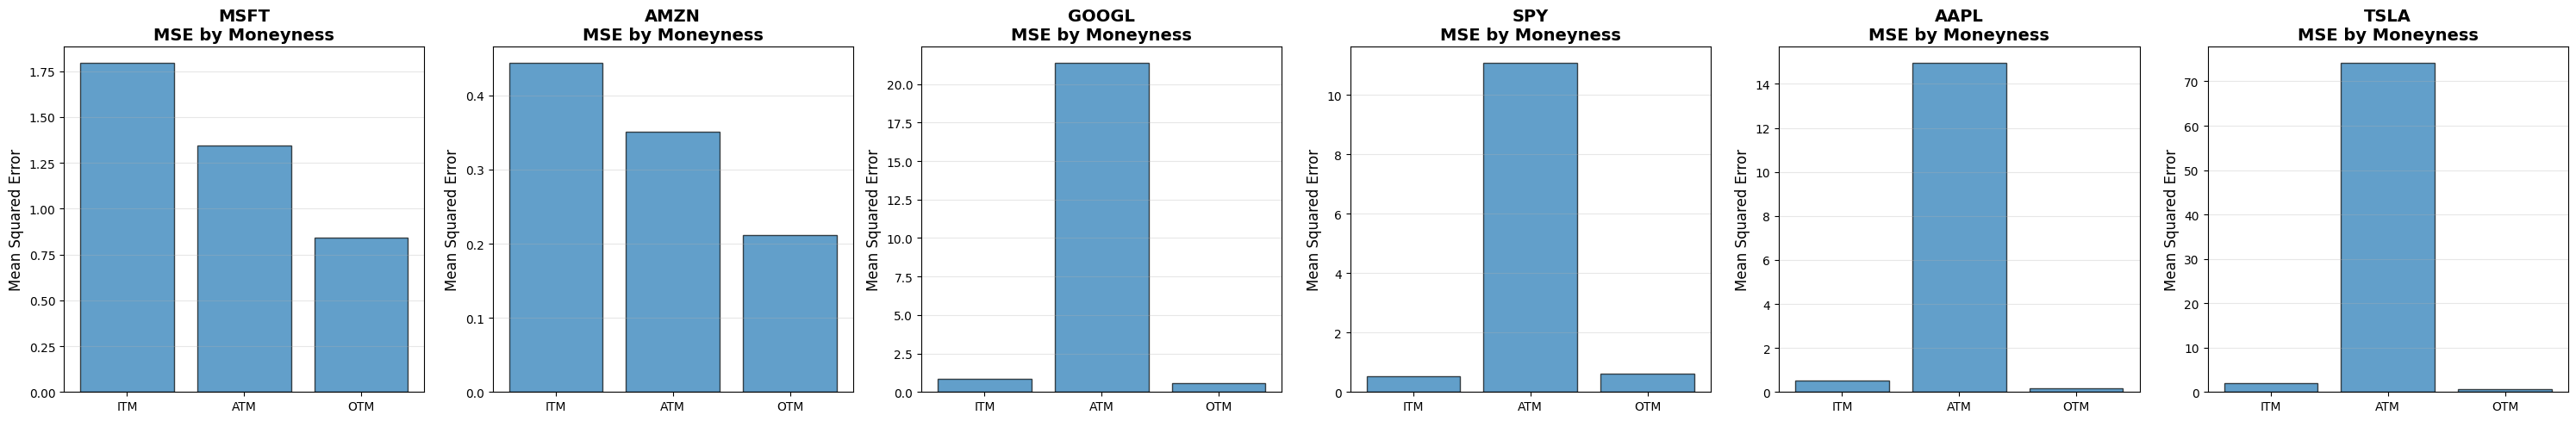

In [16]:
# Define moneyness categories
def categorize_options(x, c, F):
    atm_mask = np.abs(x) < 0.05  #  ATM
    itm_mask = x > 0.01  # ITM: F > K
    otm_mask = x < -0.01  # OTM
    return atm_mask, itm_mask, otm_mask


# Calculate MSE for each ticker and category
results = {}

for ticker in tickers:
    ticker_testing = market_testing_data[ticker]
    model_prices = price_call(models[ticker], ticker_testing)
    market_prices = ticker_testing.market_prices

    # Calculate moneyness variables
    r = ticker_testing.risk_free_rate
    T = ticker_testing.maturities
    S0 = ticker_testing.spot_price
    K = ticker_testing.strikes
    F = S0 * np.exp(r * T)
    x = np.log(F / K)
    c = market_prices * np.exp(r * T)

    # Categorize options
    deep_itm_mask, atm_mask, otm_mask = categorize_options(x, c, F)

    # Calculate MSE for each category
    mse_deep_itm = (
        np.mean((model_prices[deep_itm_mask] - market_prices[deep_itm_mask]) ** 2)
        if np.any(deep_itm_mask)
        else 0
    )
    mse_atm = (
        np.mean((model_prices[atm_mask] - market_prices[atm_mask]) ** 2)
        if np.any(atm_mask)
        else 0
    )
    mse_otm = (
        np.mean((model_prices[otm_mask] - market_prices[otm_mask]) ** 2)
        if np.any(otm_mask)
        else 0
    )

    results[ticker] = {
        "ITM": mse_deep_itm,
        "ATM": mse_atm,
        "OTM": mse_otm,
        "counts": {
            "ITM": np.sum(deep_itm_mask),
            "ATM": np.sum(atm_mask),
            "OTM": np.sum(otm_mask),
        },
    }

# Create bar graphs
fig, axes = plt.subplots(1, len(tickers), figsize=(5 * len(tickers), 5))
if len(tickers) == 1:
    axes = [axes]

categories = ["ITM", "ATM", "OTM"]

for idx, ticker in enumerate(tickers):
    mse_values = [results[ticker][cat] for cat in categories]
    counts = [results[ticker]["counts"][cat] for cat in categories]

    bars = axes[idx].bar(categories, mse_values, alpha=0.7, edgecolor="black")
    axes[idx].set_ylabel("Mean Squared Error", fontsize=12)
    axes[idx].set_title(f"{ticker}\nMSE by Moneyness", fontsize=14, fontweight="bold")
    axes[idx].grid(axis="y", alpha=0.3)


plt.tight_layout()
plt.show()

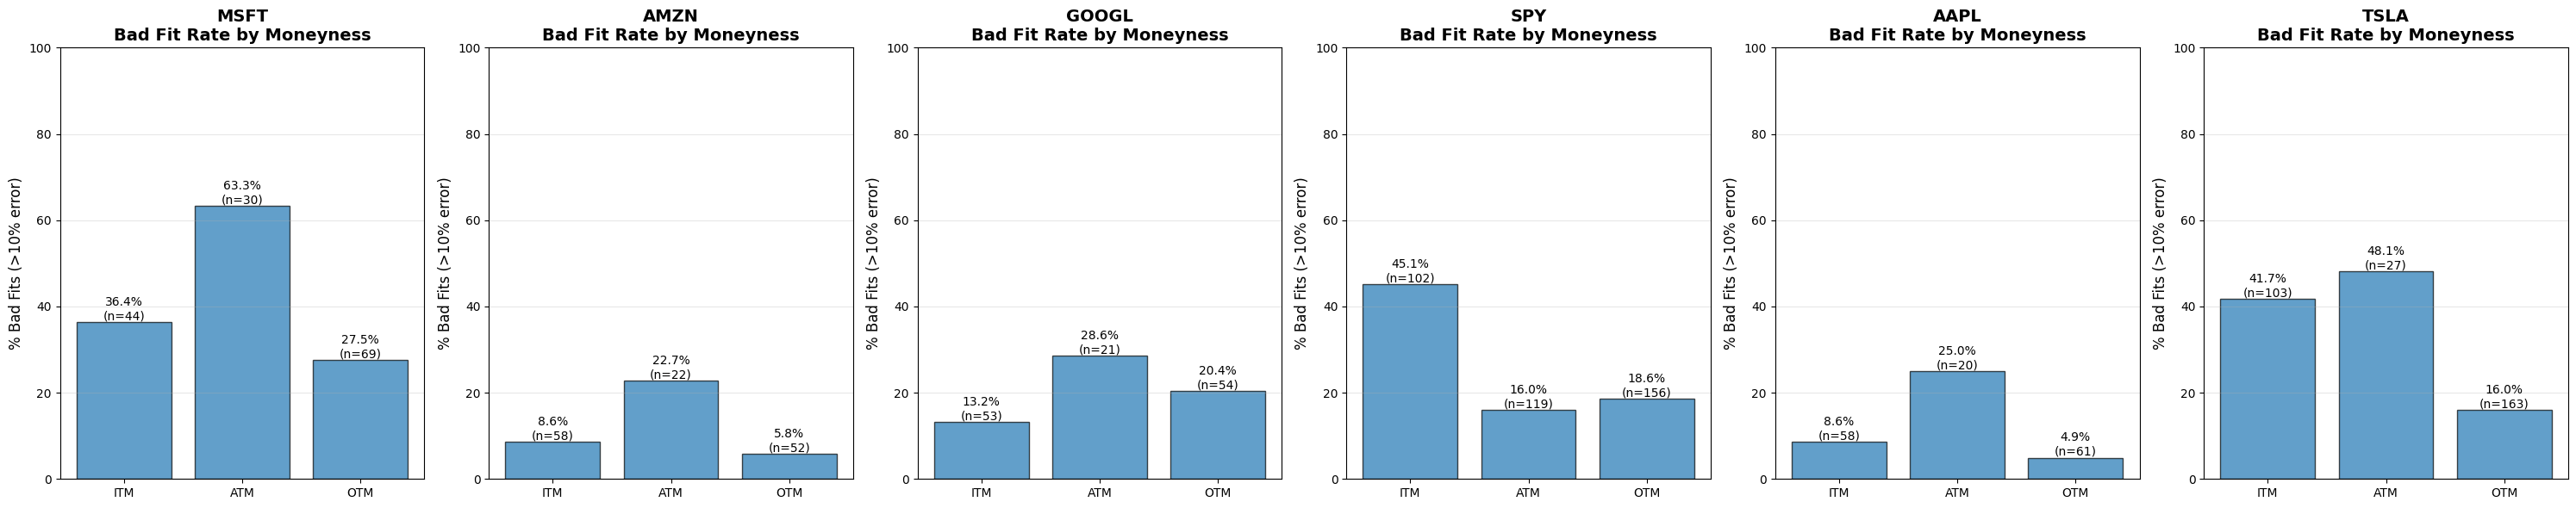

In [17]:
# Define moneyness categories
def categorize_options(x, c, F):
    """
    Categorize options by moneyness
    x: log-moneyness (log(F/K))
    c: normalized call prices
    F: forward prices
    """
    atm_mask = np.abs(x) < 0.05  # ATM
    itm_mask = x > 0.01  # ITM: F > K (low strike, high price)
    otm_mask = x < -0.01  # OTM: F < K (high strike, low price)
    return atm_mask, itm_mask, otm_mask


# Calculate good vs bad fits for each ticker and category
results = {}

for ticker in tickers:
    ticker_testing = market_testing_data[ticker]
    model_prices = price_call(models[ticker], ticker_testing)
    market_prices = ticker_testing.market_prices

    # Calculate moneyness variables
    r = ticker_testing.risk_free_rate
    T = ticker_testing.maturities
    S0 = ticker_testing.spot_price
    K = ticker_testing.strikes
    F = S0 * np.exp(r * T)
    x = np.log(F / K)
    c = market_prices * np.exp(r * T)

    # Categorize options
    atm_mask, itm_mask, otm_mask = categorize_options(x, c, F)

    # Identify good vs bad fits (threshold: 10% of market price)
    are_different = np.abs(model_prices - market_prices) > 1

    # Calculate percentage of bad fits for each category
    results[ticker] = {}
    for cat_name, cat_mask in [
        ("ITM", itm_mask),
        ("ATM", atm_mask),
        ("OTM", otm_mask),
    ]:  # Fixed label
        total = np.sum(cat_mask)
        bad = np.sum(are_different & cat_mask)
        pct_bad = 100 * bad / total if total > 0 else 0
        results[ticker][cat_name] = {"pct_bad": pct_bad, "bad": bad, "total": total}

# Create bar graphs
fig, axes = plt.subplots(1, len(tickers), figsize=(5 * len(tickers), 6))
if len(tickers) == 1:
    axes = [axes]

categories = ["ITM", "ATM", "OTM"]  # Fixed labels

for idx, ticker in enumerate(tickers):
    pct_bad_values = [results[ticker][cat]["pct_bad"] for cat in categories]
    totals = [results[ticker][cat]["total"] for cat in categories]

    bars = axes[idx].bar(categories, pct_bad_values, alpha=0.7, edgecolor="black")
    axes[idx].set_ylabel("% Bad Fits (>10% error)", fontsize=12)
    axes[idx].set_title(
        f"{ticker}\nBad Fit Rate by Moneyness", fontsize=14, fontweight="bold"
    )
    axes[idx].set_ylim(0, 100)
    axes[idx].grid(axis="y", alpha=0.3)

    # Add percentage and count labels on bars
    for bar, pct, total in zip(bars, pct_bad_values, totals):
        height = bar.get_height()
        axes[idx].text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{pct:.1f}%\n(n={total})",
            ha="center",
            va="bottom",
            fontsize=10,
        )

plt.tight_layout()
plt.show()

In [18]:


models_atm = {}
for ticker in tickers:
    iv = float((market_training_data[ticker]).initial_volatility())
    BG = HestonModel(v0=iv, v_bar=0.04, rho=-0.2, kappa=1.0, sigma=0.2)
    models_atm[ticker] = calibrate(market_training_data[ticker], guess=BG)


/Users/bubba/Documents/python notebooks/finance bootcamp /heston_project/heston.py:37: UserWarning: Feller condition not satisfied
  warnings.warn('Feller condition not satisfied')


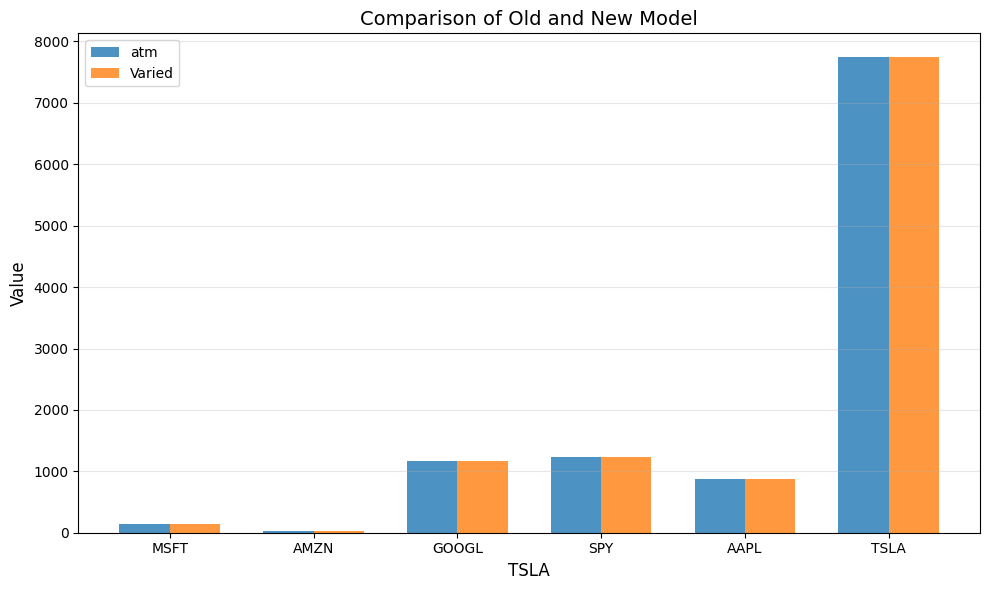

In [19]:
standard_guess = []
atm_guess = []
for ticker in tickers:
    model_prices = price_call(models[ticker], market_testing_data[ticker])
    model_atm_prices = price_call(models_atm[ticker], market_testing_data[ticker])
    prices = market_testing_data[ticker].market_prices
    atm_guess.append(sum((model_atm_prices - prices) ** 2))
    standard_guess.append(sum((model_prices - prices) ** 2))
x = np.arange(len(tickers))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width / 2, atm_guess, width, label="atm", alpha=0.8)
bars2 = ax.bar(x + width / 2, standard_guess, width, label="Varied", alpha=0.8)

# Customize the plot
ax.set_xlabel(ticker, fontsize=12)
ax.set_ylabel("Value", fontsize=12)
ax.set_title("Comparison of Old and New Model", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(tickers)
ax.legend()
ax.grid(axis="y", alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [20]:
"""
Google is bad for very clear reasons in this case: the average volatility is set to 1 (boundary condition) with an absurdly slow reversion to mean
"""

for ticker in tickers:
    print(f"{ticker} with v0 atm parameters: {models_atm[ticker]}")
    print(f"{ticker} with standard guess parameters: {models[ticker]}")

MSFT with v0 atm parameters: v0=0.06719136446968782 v_bar=0.07621095006356145 rho=-0.3615366502647117 kappa=9.999999999329468 sigma=1.0507652178376747
MSFT with standard guess parameters: v0=0.06719113095893367 v_bar=0.07621096332139708 rho=-0.36153571708687593 kappa=9.999999999999973 sigma=1.0507640633510815
AMZN with v0 atm parameters: v0=0.13762165074556126 v_bar=0.19413286012396672 rho=-0.30323358525577104 kappa=0.6767847083397359 sigma=0.7040980940277043
AMZN with standard guess parameters: v0=0.1376216445358235 v_bar=0.1941330643134624 rho=-0.3032335307895281 kappa=0.6767819547033946 sigma=0.7040974116112549
GOOGL with v0 atm parameters: v0=0.14683485734409576 v_bar=0.8923575399578061 rho=-0.2353154107147933 kappa=0.010000001851885822 sigma=0.26555723799236586
GOOGL with standard guess parameters: v0=0.14683485544290142 v_bar=0.8923526235435647 rho=-0.23531576697590195 kappa=0.010000001514542039 sigma=0.26555656496686403
SPY with v0 atm parameters: v0=0.025004151043336108 v_bar=0

In [21]:
"""we can then look  at not deep itm options, where the model is (more successful.)"""
not_deep_itm_data = {}
not_deep_models = {}
new_training_data = {}
new_testing_data = {}
not_deep_models_iv = {}

for ticker in tickers:
    not_deep_itm_data[ticker] = cleaned_data[ticker].filter_deep_itm()
    new_training_data[ticker], new_testing_data[ticker] = not_deep_itm_data[
        ticker
    ].testing()
    not_deep_models[ticker] = calibrate(new_training_data[ticker])
    not_deep_models_iv[ticker] = calibrate_iv(new_training_data[ticker])
for ticker in tickers:
    print(
        f"{cleaned_data[ticker].market_prices.size - not_deep_itm_data[ticker].market_prices.size} points removed for {ticker}"
    )


/Users/bubba/Documents/python notebooks/finance bootcamp /heston_project/heston.py:37: UserWarning: Feller condition not satisfied
  warnings.warn('Feller condition not satisfied')


20 points removed for MSFT
16 points removed for AMZN
25 points removed for GOOGL
16 points removed for SPY
60 points removed for AAPL
78 points removed for TSLA


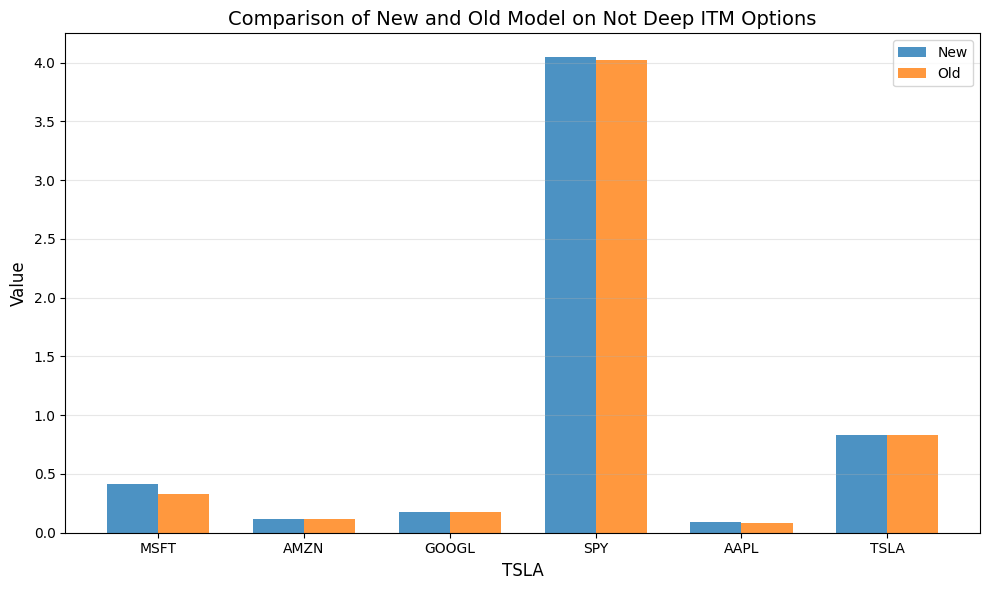

In [22]:
new = []
old = []

for ticker in tickers:
    new_model_prices = price_call(not_deep_models[ticker], new_testing_data[ticker])
    model_prices = price_call(models[ticker], new_testing_data[ticker])
    prices = new_testing_data[ticker].market_prices
    new.append(sum((new_model_prices - prices) ** 2) / market_prices.size)
    old.append(sum((model_prices - prices) ** 2) / market_prices.size)

x = np.arange(len(tickers))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width / 2, new, width, label="New", alpha=0.8)
bars2 = ax.bar(x + width / 2, old, width, label="Old", alpha=0.8)

# Customize the plot
ax.set_xlabel(ticker, fontsize=12)
ax.set_ylabel("Value", fontsize=12)
ax.set_title("Comparison of New and Old Model on Not Deep ITM Options", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(tickers)
ax.legend()
ax.grid(axis="y", alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

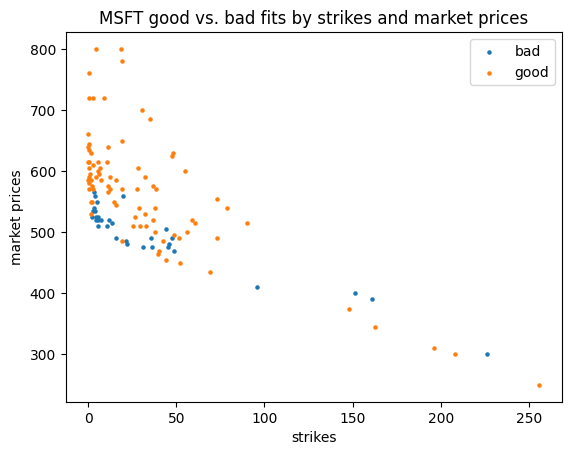

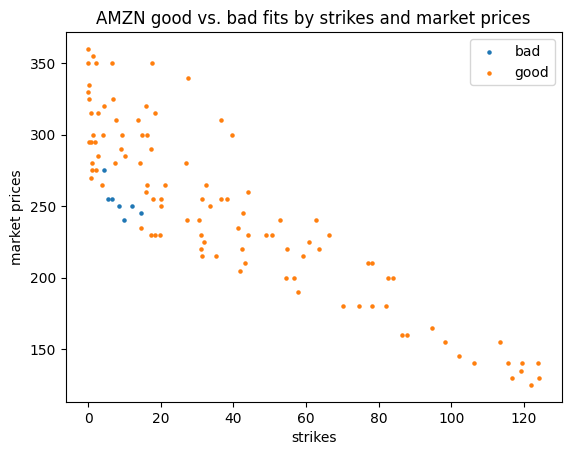

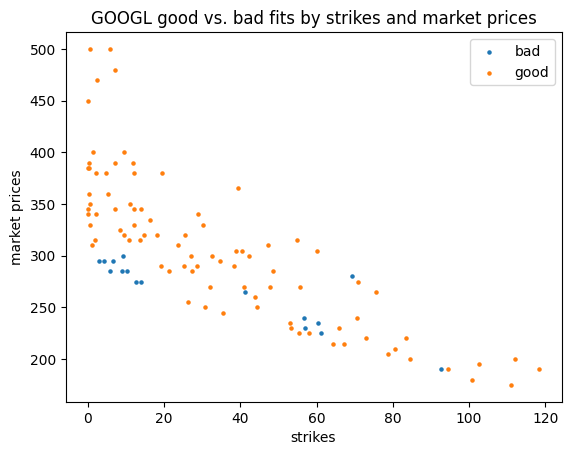

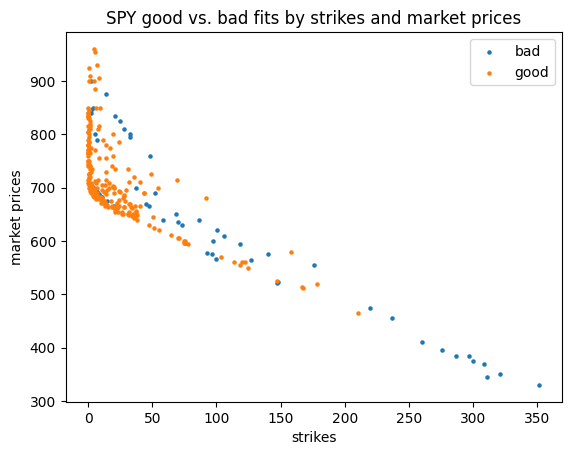

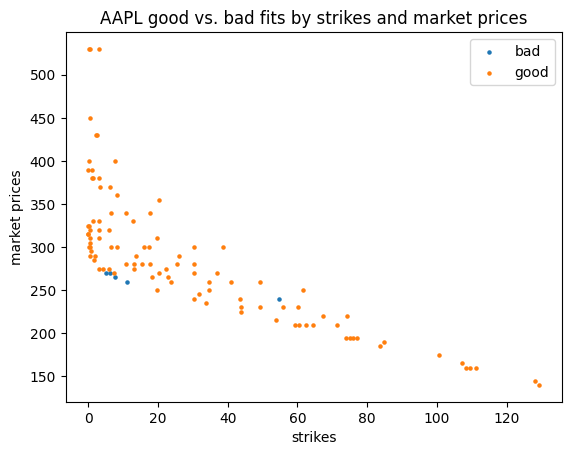

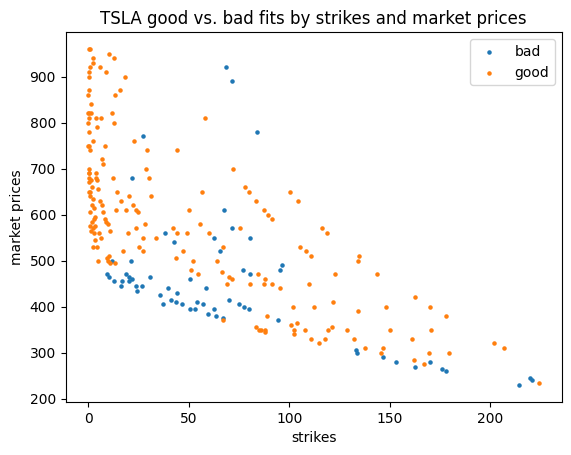

In [23]:
for ticker in tickers:
    ticker_testing = new_testing_data[ticker]
    new_model_prices = price_call(not_deep_models[ticker], ticker_testing)
    prices = ticker_testing.market_prices
    # square difference more than 10% of market price
    are_different = abs(new_model_prices - prices) > 1
    are_close = ~are_different

    r = ticker_testing.risk_free_rate
    T = ticker_testing.maturities
    S0 = ticker_testing.spot_price
    K = ticker_testing.strikes
    F = S0 * np.exp(r * T)
    x = np.log(F / K)
    c = prices * np.exp(r * T)

    testing_prices = price_call(models[ticker], ticker_testing)
    plt.scatter(
        ticker_testing.market_prices[are_different],
        ticker_testing.strikes[are_different],
        label="bad",
        s=5,
    )
    plt.scatter(
        ticker_testing.market_prices[are_close],
        ticker_testing.strikes[are_close],
        label="good",
        s=5,
    )
    plt.xlabel("strikes")
    plt.ylabel("market prices")
    plt.legend()
    plt.title(f"{ticker} good vs. bad fits by strikes and market prices")
    plt.show()

In [24]:
# Calibrate with regularization
BD = [(0.001, 1.0), (0.001, 1.0), (-0.999, 0.999), (0.01, 10.0), (0.01, 2.0)]
for ticker in tickers:
    iv = float((market_training_data[ticker]).initial_volatility())
    BG = HestonModel(v0=iv, v_bar=0.04, rho=-0.2, kappa=1.0, sigma=0.2)


def calibrate_regularized(
    md: MarketData,
    bounds=BD,
    guess: HestonModel = IG,
    lambda_tikhonov=0.01,
    lambda_feller=100.0,
) -> HestonModel:
    # a little hacky. start with initial volatility for short term atm options
    iv = float(md.initial_volatility())
    # Convert initial guess to array (serves as prior for Tikhonov)
    x0 = np.array([iv, guess.v_bar, guess.rho, guess.kappa, guess.sigma])
    prior = x0.copy()

    S0 = md.spot_price
    r = md.risk_free_rate
    strikes = md.strikes
    maturities = md.maturities
    market_prices = md.market_prices
    n_obs = len(market_prices)

    def residuals_wrapper(x):
        v0, v_bar, rho, kappa, sigma = x
        theta = HestonModel(v0=v0, v_bar=v_bar, rho=rho, kappa=kappa, sigma=sigma)
        model_prices = theta._heston_price_call(S0, r, strikes, maturities)

        # Market fit residuals
        market_residuals = model_prices - market_prices

        # Feller condition penalty: 2*kappa*v_bar > sigma^2
        feller_violation = max(0, sigma**2 - 2 * kappa * v_bar)
        feller_penalty = np.sqrt(lambda_feller * n_obs) * feller_violation

        # Tikhonov regularization: penalize deviation from prior
        # Weight each parameter appropriately
        weights = np.array([1.0, 1.0, 0.5, 0.5, 1.0])  # [v0, v_bar, rho, kappa, sigma]
        tikhonov_residuals = np.sqrt(lambda_tikhonov) * weights * (x - prior)

        # Combine all residuals
        return np.concatenate([market_residuals, [feller_penalty], tikhonov_residuals])

    def jac_wrapper(x):
        v0, v_bar, rho, kappa, sigma = x
        theta = HestonModel(v0=v0, v_bar=v_bar, rho=rho, kappa=kappa, sigma=sigma)

        # Market fit Jacobian (n_obs x 5)
        market_jac = theta._gradient(S0, r, strikes, maturities).T

        # Feller condition Jacobian (1 x 5)
        # d/dx max(0, sigma^2 - 2*kappa*v_bar)
        feller_violation = sigma**2 - 2 * kappa * v_bar
        if feller_violation > 0:
            feller_jac = np.sqrt(lambda_feller * n_obs) * np.array(
                [
                    0,  # d/dv0
                    -2 * kappa,  # d/dv_bar
                    0,  # d/drho
                    -2 * v_bar,  # d/dkappa
                    2 * sigma,  # d/dsigma
                ]
            )
        else:
            feller_jac = np.zeros(5)

        # Tikhonov Jacobian (5 x 5 diagonal)
        weights = np.array([1.0, 1.0, 0.5, 0.5, 1.0])
        tikhonov_jac = np.sqrt(lambda_tikhonov) * np.diag(weights)

        # Combine all Jacobians
        return np.vstack([market_jac, feller_jac.reshape(1, -1), tikhonov_jac])

    # Convert bounds
    lower_bounds = np.array([0.001, 0.001, -0.999, 0.01, 0.01])
    upper_bounds = np.array([1.0, 1.0, 0.999, 10.0, 2.0])

    result = least_squares(
        residuals_wrapper,
        x0=x0,
        jac=jac_wrapper,
        bounds=(lower_bounds, upper_bounds),
        verbose=0,
    )

    # Check if Feller condition is satisfied
    final_params = result.x
    feller_satisfied = 2 * final_params[3] * final_params[1] > final_params[4] ** 2
    if not feller_satisfied:
        print(
            f"Warning: Feller condition violated - 2κθ = {2 * final_params[3] * final_params[1]:.4f} < σ² = {final_params[4] ** 2:.4f}"
        )

    # Return as HestonModel object
    return HestonModel(
        v0=result.x[0],
        v_bar=result.x[1],
        rho=result.x[2],
        kappa=result.x[3],
        sigma=result.x[4],
    )

In [25]:
# we will stick to not deep itm stocks that are also cleaned for outliers as before.
# when initializing at instantaneous volatility, we sometimes violate the feller condition. Let's fix that.
# additionally, we are getting sigma and kappa offset each other. In the some cases we are getting absurd kappa. We will
# try to make some gently suggestions for better generalization
models = {}
models_regularized = {}
models_only_feller = {}
models_only_tikhonov = {}
for ticker in tickers:
    cleaned_data[ticker] = market_data[ticker].remove_outliers().filter_deep_itm()
    new_training_data[ticker], new_testing_data[ticker] = cleaned_data[ticker].testing()


for ticker in tickers:
    models[ticker] = calibrate_regularized(
        new_training_data[ticker], lambda_feller=0, lambda_tikhonov=0
    )
    models_regularized[ticker] = calibrate_regularized(new_training_data[ticker])
    models_only_feller[ticker] = calibrate_regularized(
        new_training_data[ticker], lambda_tikhonov=0
    )
    models_only_tikhonov[ticker] = calibrate_regularized(
        new_training_data[ticker], lambda_feller=0
    )

/Users/bubba/Documents/python notebooks/finance bootcamp /heston_project/heston.py:37: UserWarning: Feller condition not satisfied
  warnings.warn('Feller condition not satisfied')


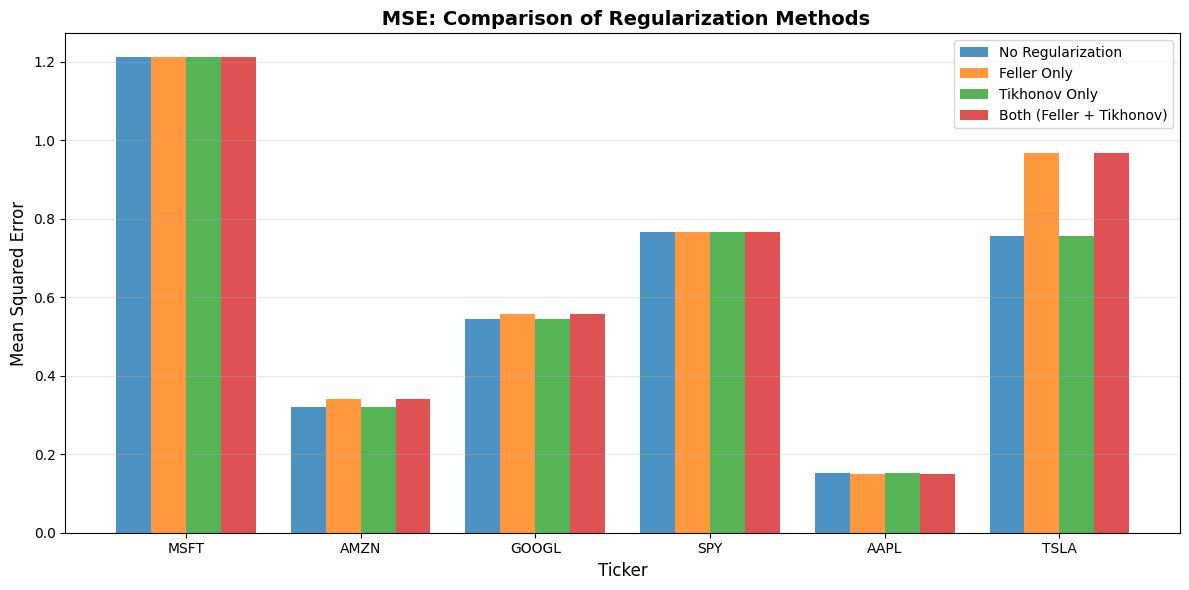

In [26]:
new = []
regular = []
only_feller = []
only_tikhonov = []

for ticker in tickers:
    new_model_prices = price_call(models[ticker], new_testing_data[ticker])
    regular_model_prices = price_call(
        models_regularized[ticker], new_testing_data[ticker]
    )
    feller_model_prices = price_call(models_only_feller[ticker], new_testing_data[ticker])
    tikhonov_model_prices = price_call(
        models_only_tikhonov[ticker], new_testing_data[ticker]
    )

    prices = new_testing_data[ticker].market_prices

    new.append(sum((new_model_prices - prices) ** 2) / prices.size)
    regular.append(sum((regular_model_prices - prices) ** 2) / prices.size)
    only_feller.append(sum((feller_model_prices - prices) ** 2) / prices.size)
    only_tikhonov.append(sum((tikhonov_model_prices - prices) ** 2) / prices.size)

x = np.arange(len(tickers))
width = 0.2  # Narrower bars to fit 4 groups

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5 * width, new, width, label="No Regularization", alpha=0.8)
bars2 = ax.bar(x - 0.5 * width, only_feller, width, label="Feller Only", alpha=0.8)
bars3 = ax.bar(x + 0.5 * width, only_tikhonov, width, label="Tikhonov Only", alpha=0.8)
bars4 = ax.bar(
    x + 1.5 * width, regular, width, label="Both (Feller + Tikhonov)", alpha=0.8
)

# Customize the plot
ax.set_xlabel("Ticker", fontsize=12)
ax.set_ylabel("Mean Squared Error", fontsize=12)
ax.set_title(
    " MSE: Comparison of Regularization Methods",
    fontsize=14,
    fontweight="bold",
)
ax.set_xticks(x)
ax.set_xticklabels(tickers)
ax.legend(fontsize=10)
ax.grid(axis="y", alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [27]:
for ticker in tickers:
    print(ticker)
    print(f"fully regular: {models_regularized[ticker]}")
    print(f"no regularization: {not_deep_models[ticker]}")

MSFT
fully regular: v0=0.07302916631119849 v_bar=0.0799875459208135 rho=-0.33030682825036056 kappa=1.7503819408681769 sigma=0.4031298076797811
no regularization: v0=0.07298945678292153 v_bar=0.08254788140160889 rho=-0.32374081440861796 kappa=1.3084633126452163 sigma=0.37689338261395566
AMZN
fully regular: v0=0.13707764113352347 v_bar=0.1597322476590952 rho=-0.36304646933690776 kappa=1.0677453505169427 sigma=0.5850813976722026
no regularization: v0=0.13748327076561165 v_bar=0.19141457015028776 rho=-0.3100505949552935 kappa=0.6737246226575118 sigma=0.6766703546145301
GOOGL
fully regular: v0=0.14849721400962854 v_bar=0.1704801883769653 rho=-0.24591471374209564 kappa=0.26688052657416633 sigma=0.30382082121122284
no regularization: v0=0.14627524610883685 v_bar=0.9999999978907811 rho=-0.23565083102720877 kappa=0.012821295990641413 sigma=0.29663469010719495
SPY
fully regular: v0=0.024791615612171563 v_bar=0.031145266194041035 rho=-0.800480038601994 kappa=1.5965276066374574 sigma=0.29777658090

In [28]:
# Really most of the difference is made up by very few data points. In these, we can compare to black-scholes
# where we use sigma=initial volatility (note that this is computed apriori--that is just taking any short term atm stock)
# the bs call is very close to heston call in this case, but still radically different from market


google_data: MarketData = new_testing_data["GOOGL"]
google_model = price_call(models_regularized["GOOGL"], new_testing_data["GOOGL"])
initial_vol = new_testing_data["GOOGL"].initial_volatility()
bs_prices = bs_call(
    S0=google_data.spot_price,
    K=google_data.strikes,
    sigma=initial_vol,
    T=google_data.maturities,
    r=google_data.risk_free_rate,
)
# Calculate squared error normalized by number of observations
squared_errors = (google_model - google_data.market_prices) ** 2 / len(
    google_data.market_prices
)
heston_to_bs = (google_model - bs_prices) ** 2 / len(google_data.market_prices)

# Create DataFrame
df = pd.DataFrame(
    {
        "market_price": google_data.market_prices,
        "maturity": google_data.maturities,
        "strike": google_data.strikes,
        "model_price": google_model,
        "bs_price": bs_prices,
        "heston_to_market_sq_error": squared_errors,
        "heston_to_bs_sq_error": heston_to_bs,
    }
)
print(f"current implied vol (atm short): {initial_vol}")

# Sort by squared error (highest first)
df = df.sort_values("heston_to_market_sq_error", ascending=False).reset_index(drop=True)
print(google_data.spot_price)
print(df.head(10))

current implied vol (atm short): 0.32818066998476664
278.8299865722656
   market_price  maturity  strike  model_price   bs_price  \
0         9.200  0.189041   300.0    11.030356   8.641825   
1         7.025  0.093151   290.0     8.785767   6.999136   
2         8.350  0.112329   290.0    10.104300   8.126975   
3         9.000  0.093151   285.0    10.738073   8.868247   
4        11.250  0.093151   280.0    12.983441  11.075504   
5         6.500  0.189041   310.0     8.181643   6.067774   
6         5.700  0.073973   290.0     7.347974   5.777370   
7         5.500  0.093151   295.0     7.111088   5.444626   
8         5.300  0.112329   300.0     6.868150   5.139591   
9        18.250  0.112329   270.0    19.709653  17.689611   

   heston_to_market_sq_error  heston_to_bs_sq_error  
0                   0.032213               0.054857  
1                   0.029811               0.030693  
2                   0.029592               0.037594  
3                   0.029047             

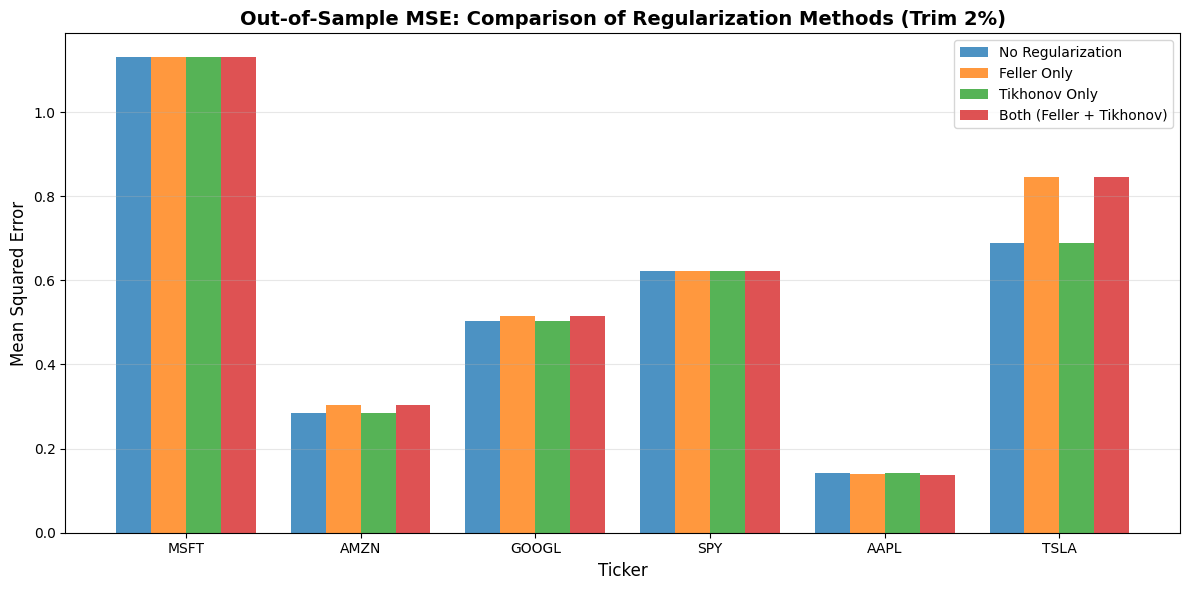

In [29]:
def trimmed_mse(model_prices, market_prices, trim_pct=0.02):
    squared_errors = (model_prices - market_prices) ** 2
    n_trim = int(len(squared_errors) * trim_pct)

    # Sort and remove top and bottom n_trim errors
    sorted_errors = np.sort(squared_errors)
    if n_trim > 0:
        trimmed = sorted_errors[n_trim:-n_trim]
    else:
        trimmed = sorted_errors

    return trimmed.mean()


new = []
regular = []
only_feller = []
only_tikhonov = []
for ticker in tickers:
    new_model_prices = price_call(models[ticker], new_testing_data[ticker])
    regular_model_prices = price_call(
        models_regularized[ticker], new_testing_data[ticker]
    )
    feller_model_prices = price_call(models_only_feller[ticker], new_testing_data[ticker])
    tikhonov_model_prices = price_call(
        models_only_tikhonov[ticker], new_testing_data[ticker]
    )

    prices = new_testing_data[ticker].market_prices

    new.append(trimmed_mse(new_model_prices, prices))
    regular.append(trimmed_mse(regular_model_prices, prices))
    only_feller.append(trimmed_mse(feller_model_prices, prices))
    only_tikhonov.append(trimmed_mse(tikhonov_model_prices, prices))

x = np.arange(len(tickers))
width = 0.2  # Narrower bars to fit 4 groups

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5 * width, new, width, label="No Regularization", alpha=0.8)
bars2 = ax.bar(x - 0.5 * width, only_feller, width, label="Feller Only", alpha=0.8)
bars3 = ax.bar(x + 0.5 * width, only_tikhonov, width, label="Tikhonov Only", alpha=0.8)
bars4 = ax.bar(
    x + 1.5 * width, regular, width, label="Both (Feller + Tikhonov)", alpha=0.8
)

# Customize the plot
ax.set_xlabel("Ticker", fontsize=12)
ax.set_ylabel("Mean Squared Error", fontsize=12)
ax.set_title(
    "Out-of-Sample MSE: Comparison of Regularization Methods (Trim 2%)",
    fontsize=14,
    fontweight="bold",
)
ax.set_xticks(x)
ax.set_xticklabels(tickers)
ax.legend(fontsize=10)
ax.grid(axis="y", alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [30]:
# cross validation
"""
lambdas = [0.00, 0.01, 0.02, 0.03, 0.04, .05]
best_lambda = None
best_oos_error = float('inf')
best_models={}
for ticker in tickers:
    for lam in lambdas:
        # Calibrate on training data
        model = calibrate_regularized(new_training_data[ticker], lambda_tikhonov=lam)
        prices=new_training_data
        # Evaluate on validation data
        oos_error = (price_call(model, new_training_data)-
        
        if oos_error < best_oos_error:
            best_oos_error = oos_error
            best_lambda = lam

    # Use best_lambda for final calibration
    final_model = calibrate_regularized(full_data, lambda_tikhonov=best_lambda)
    """


"\nlambdas = [0.00, 0.01, 0.02, 0.03, 0.04, .05]\nbest_lambda = None\nbest_oos_error = float('inf')\nbest_models={}\nfor ticker in tickers:\n    for lam in lambdas:\n        # Calibrate on training data\n        model = calibrate_regularized(new_training_data[ticker], lambda_tikhonov=lam)\n        prices=new_training_data\n        # Evaluate on validation data\n        oos_error = (price_call(model, new_training_data)-\n\n        if oos_error < best_oos_error:\n            best_oos_error = oos_error\n            best_lambda = lam\n\n    # Use best_lambda for final calibration\n    final_model = calibrate_regularized(full_data, lambda_tikhonov=best_lambda)\n    "

In [ ]:
def validate_option_data(
    md: MarketData,
    tolerance=0.01,
    check_monotonicity=False,
    check_iv=False,
    iv_multiplier=3.0,
    return_outliers=False,
):
    S0 = md.spot_price
    K = md.strikes
    T = md.maturities
    r = md.risk_free_rate
    C = md.market_prices

    valid_mask = np.ones(len(C), dtype=bool)

    arbitrage_lower = 0
    arbitrage_upper = 0
    monotonicity_violations = 0
    iv_violations = 0

    # 1. No-arbitrage lower bound: C >= max(S0 - K*exp(-rT), 0)
    lower_bound = np.maximum(S0 - K * np.exp(-r * T), 0)
    lower_violations = C < lower_bound - tolerance
    valid_mask &= ~lower_violations
    arbitrage_lower = lower_violations.sum()

    # 2. No-arbitrage upper bound: C <= S0
    upper_violations = C > S0 + tolerance
    valid_mask &= ~upper_violations
    arbitrage_upper = upper_violations.sum()

    # 3. Monotonicity in strike: calls should decrease with strike (for same maturity)
    if check_monotonicity:
        for t in np.unique(T):
            t_mask = T == t
            t_indices = np.where(t_mask)[0]
            t_strikes = K[t_mask]
            t_prices = C[t_mask]

            # Sort by strike
            sorted_idx = np.argsort(t_strikes)
            sorted_prices = t_prices[sorted_idx]

            # Check monotonicity: price should decrease (or stay flat within tolerance)
            for i in range(len(sorted_prices) - 1):
                if sorted_prices[i + 1] > sorted_prices[i] + tolerance:  # Violation
                    # Flag only the option with higher price (likely the error)
                    actual_idx_next = t_indices[sorted_idx[i + 1]]
                    if valid_mask[actual_idx_next]:  # Only count if not already flagged
                        monotonicity_violations += 1
                    valid_mask[actual_idx_next] = False

    # Reasonable IV check
    if check_iv:
        ivs = __implied_volatility(C, S0, K, T, r)

        for t in np.unique(T):
            t_mask = (T == t) & valid_mask
            if not np.any(t_mask):
                continue

            t_strikes = K[t_mask]
            t_ivs = ivs[t_mask]

            # Find ATM
            F = S0 * np.exp(r * t)
            atm_idx = np.argmin(np.abs(t_strikes - F))
            atm_iv = t_ivs[atm_idx]

            if np.isnan(atm_iv):
                continue

            # get extreme IV relative to ATM
            t_indices = np.where(t_mask)[0]
            iv_too_high = t_ivs > iv_multiplier * atm_iv
            iv_too_low = t_ivs < atm_iv / iv_multiplier
            iv_is_nan = np.isnan(t_ivs)

            extreme_iv_mask = iv_too_high | iv_too_low | iv_is_nan

            # Count violations (only those currently valid)
            iv_violations += np.sum(extreme_iv_mask & valid_mask[t_indices])

            # Update valid_mask
            valid_mask[t_indices] = valid_mask[t_indices] & ~extreme_iv_mask

    total_removed = (~valid_mask).sum()
    total = len(C)
    print(f"Removed {total_removed} / {total} options ({100 * total_removed / total:.1f}%)")
    print(f"  - Lower bound violations: {arbitrage_lower}")
    print(f"  - Upper bound violations: {arbitrage_upper}")
    if check_monotonicity:
        print(f"  - Monotonicity violations: {monotonicity_violations}")
    if check_iv:
        print(f"  - IV outliers/unsolvable: {iv_violations}")
    if not return_outliers:
        return MarketData(
            spot_price=S0,
            risk_free_rate=r,
            strikes=K[valid_mask],
            maturities=T[valid_mask],
            market_prices=C[valid_mask],
        )
    else:
        removed = ~valid_mask
        return MarketData(
            spot_price=S0,
            risk_free_rate=r,
            strikes=K[valid_mask],
            maturities=T[valid_mask],
            market_prices=C[valid_mask],
        ), MarketData(
            spot_price=S0,
            risk_free_rate=r,
            strikes=K[removed],
            maturities=T[removed],
            market_prices=C[removed],
        )

clean_google_data = validate_option_data(
google_data, check_iv=True, check_monotonicity=True,return_outliers=False)


Removed 3 / 104 options (2.9%)
  - Lower bound violations: 0
  - Upper bound violations: 0
  - Monotonicity violations: 0
  - IV outliers/unsolvable: 3
<class 'marketdata.MarketData'>


In [32]:
google_model = price_call(models_regularized["GOOGL"], clean_google_data)
initial_vol = (clean_google_data).initial_volatility()
bs_prices = bs_call(
    S0=clean_google_data.spot_price,
    K=clean_google_data.strikes,
    sigma=initial_vol,
    T=clean_google_data.maturities,
    r=clean_google_data.risk_free_rate,
)
# Calculate squared error normalized by number of observations
squared_errors = (google_model - clean_google_data.market_prices) ** 2 / len(
    clean_google_data.market_prices
)
heston_to_bs = (google_model - bs_prices) ** 2 / len(clean_google_data.market_prices)

# Create DataFrame
df = pd.DataFrame(
    {
        "market_price": clean_google_data.market_prices,
        "maturity": clean_google_data.maturities,
        "strike": clean_google_data.strikes,
        "model_price": google_model,
        "heston_to_market_sq_error": squared_errors,
        "bs_price": bs_prices,
        "heston_to_bs_sq_error": heston_to_bs,
    }
)
print(f"current implied vol (atm short): {initial_vol}")

# Sort by squared error (highest first)
df = df.sort_values("heston_to_market_sq_error", ascending=False).reset_index(drop=True)
print(clean_google_data.spot_price)
print(df.head(10))

current implied vol (atm short): 0.32818066998476664
278.8299865722656
   market_price  maturity  strike  model_price  heston_to_market_sq_error  \
0         9.200  0.189041   300.0    11.030356                   0.033170   
1         7.025  0.093151   290.0     8.785767                   0.030696   
2         8.350  0.112329   290.0    10.104300                   0.030471   
3         9.000  0.093151   285.0    10.738073                   0.029910   
4        11.250  0.093151   280.0    12.983441                   0.029751   
5         6.500  0.189041   310.0     8.181643                   0.027999   
6         5.700  0.073973   290.0     7.347974                   0.026889   
7         5.500  0.093151   295.0     7.111088                   0.025699   
8         5.300  0.112329   300.0     6.868150                   0.024347   
9        18.250  0.112329   270.0    19.709653                   0.021095   

    bs_price  heston_to_bs_sq_error  
0   8.641825               0.056486  
1   6

In [33]:
#we can visualize this data again
sensible_data={}
insensible_data={}
for ticker in tickers:
    sensible_data[ticker],insensible_data[ticker]=validate_option_data(cleaned_data[ticker],check_iv=True,check_monotonicity=True,return_outliers=True)


Removed 68 / 462 options (14.7%)
  - Lower bound violations: 5
  - Upper bound violations: 0
  - Monotonicity violations: 0
  - IV outliers/unsolvable: 63
Removed 38 / 439 options (8.7%)
  - Lower bound violations: 0
  - Upper bound violations: 0
  - Monotonicity violations: 0
  - IV outliers/unsolvable: 38
Removed 39 / 413 options (9.4%)
  - Lower bound violations: 8
  - Upper bound violations: 0
  - Monotonicity violations: 1
  - IV outliers/unsolvable: 30
Removed 235 / 1109 options (21.2%)
  - Lower bound violations: 89
  - Upper bound violations: 0
  - Monotonicity violations: 1
  - IV outliers/unsolvable: 145
Removed 103 / 427 options (24.1%)
  - Lower bound violations: 28
  - Upper bound violations: 0
  - Monotonicity violations: 0
  - IV outliers/unsolvable: 75
Removed 57 / 1003 options (5.7%)
  - Lower bound violations: 0
  - Upper bound violations: 0
  - Monotonicity violations: 0
  - IV outliers/unsolvable: 57


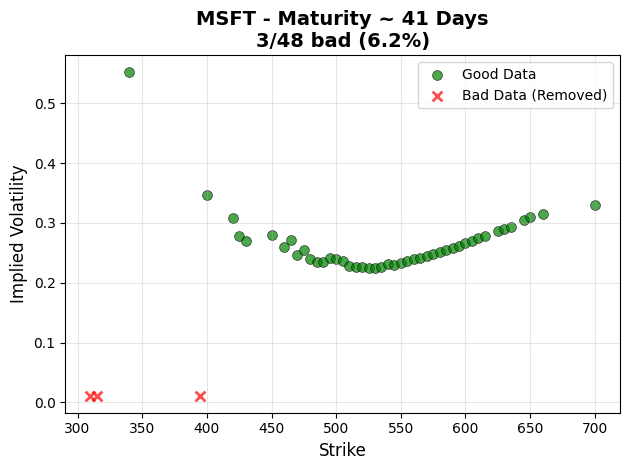

AMZN: No maturities with >5% bad data in the 0.1-0.3 year range


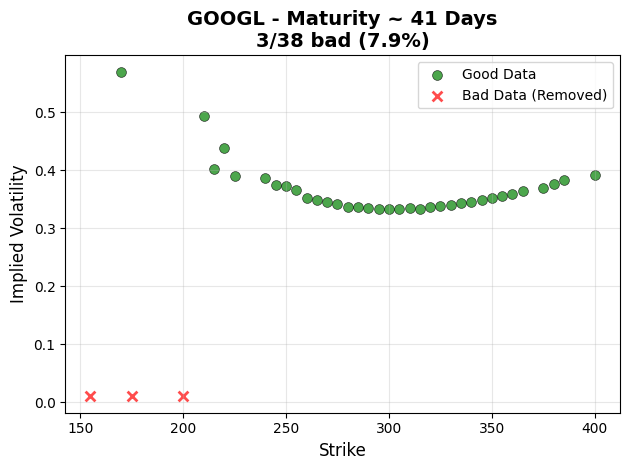

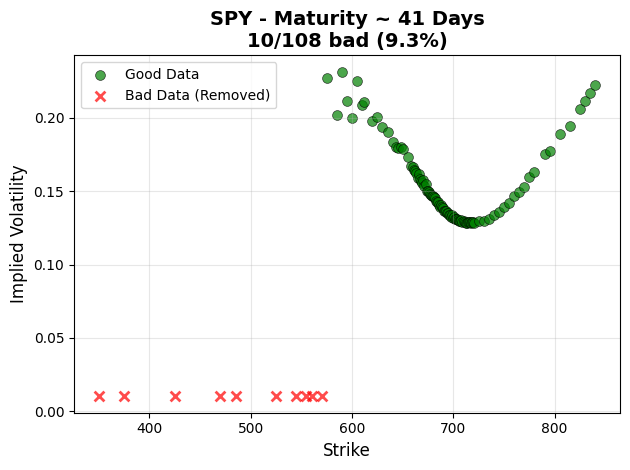

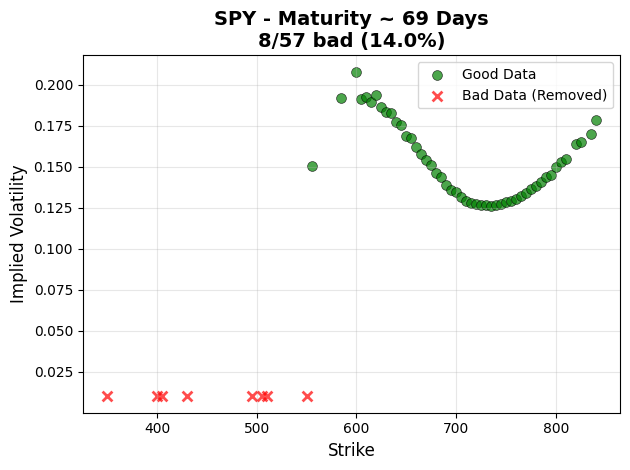

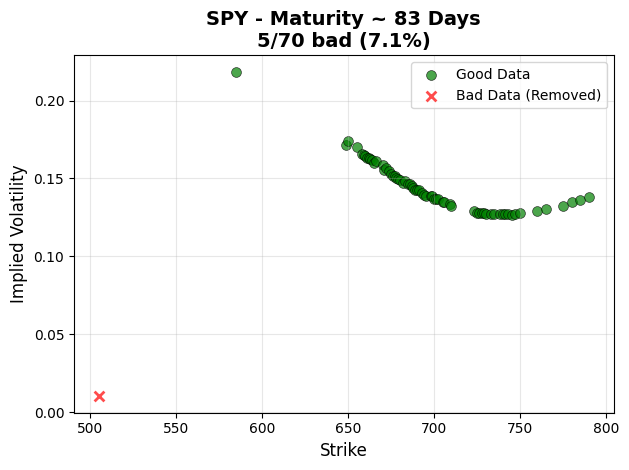

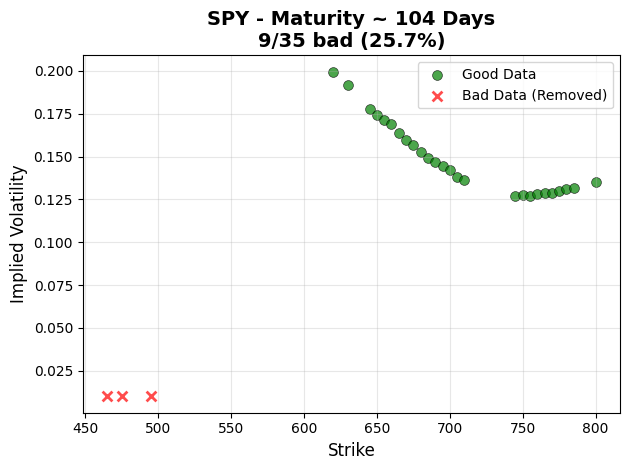

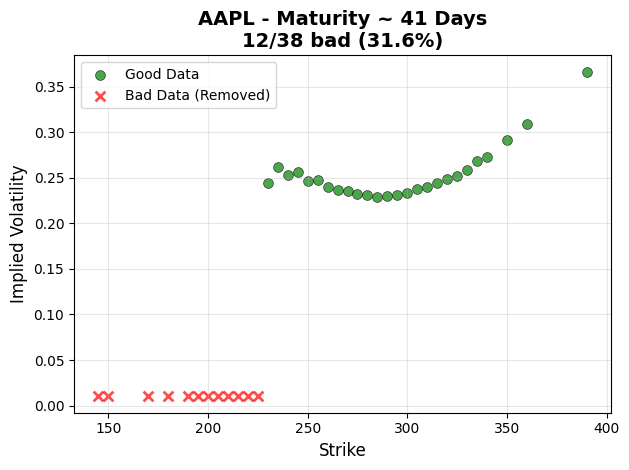

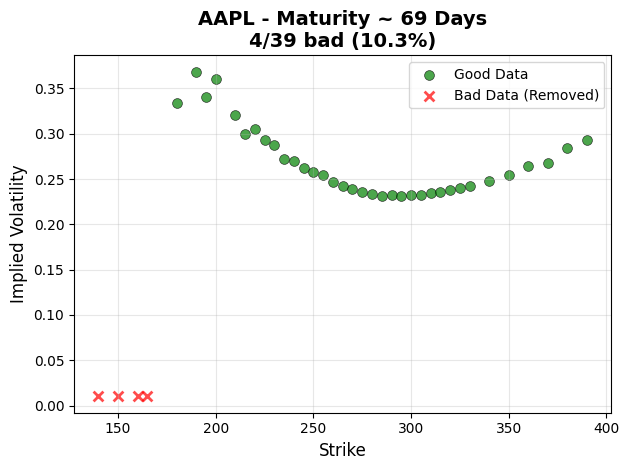

TSLA: No maturities with >5% bad data in the 0.1-0.3 year range


In [34]:
for ticker in tickers:
    ticker_data = cleaned_data[ticker]
    good_data = sensible_data[ticker]
    bad_data = insensible_data[ticker]
    
    unique_maturities = np.unique(ticker_data.maturities)
    short_mask = (unique_maturities < 0.3) & (unique_maturities > 0.1)
    candidate_maturities = unique_maturities[short_mask]
    
    # Filter to only maturities where >5% of data was bad
    some_maturities = []
    for date in candidate_maturities:
        # Count total options for this maturity (good + bad)
        n_good = np.sum(good_data.maturities == date)
        n_bad = np.sum(bad_data.maturities == date)
        n_total = n_good + n_bad
        
        if n_total > 0:
            pct_bad = n_bad / n_total
            if pct_bad > 0.05:  # More than 5% bad
                some_maturities.append(date)
    
    if len(some_maturities) == 0:
        print(f"{ticker}: No maturities with >5% bad data in the 0.1-0.3 year range")
        continue
    
    for date in some_maturities:
        # All data (cleaned)
        date_mask_all = ticker_data.maturities == date
        strikes_all = ticker_data.strikes[date_mask_all]
        ivs_all = (ticker_data.implied_volatility())[date_mask_all]
        
        # Good data
        date_mask_good = good_data.maturities == date
        if np.any(date_mask_good):
            strikes_good = good_data.strikes[date_mask_good]
            ivs_good = (good_data.implied_volatility())[date_mask_good]
            plt.scatter(strikes_good, ivs_good, c='green', label='Good Data', 
                       s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
        
        # Bad data
        date_mask_bad = bad_data.maturities == date
        if np.any(date_mask_bad):
            strikes_bad = bad_data.strikes[date_mask_bad]
            ivs_bad = (bad_data.implied_volatility())[date_mask_bad]
            plt.scatter(strikes_bad, ivs_bad, c='red', label='Bad Data (Removed)', 
                       s=50, alpha=0.7, marker='x', linewidth=2)
        
        # Calculate stats for title
        n_good = np.sum(date_mask_good)
        n_bad = np.sum(date_mask_bad)
        pct_bad = 100 * n_bad / (n_good + n_bad)
        
        plt.xlabel('Strike', fontsize=12)
        plt.ylabel('Implied Volatility', fontsize=12)
        plt.title(f"{ticker} - Maturity ~ {int(date * 365)} Days\n{n_bad}/{n_good+n_bad} bad ({pct_bad:.1f}%)", 
                 fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

In [44]:
final_models = {}
final_models_regularized = {}
final_models_only_feller = {}
final_models_only_tikhonov = {}

for ticker in tickers:
    
    new_training_data[ticker], new_testing_data[ticker] = sensible_data[ticker].testing()


for ticker in tickers:
    final_models[ticker] = calibrate_regularized(
        new_training_data[ticker], lambda_feller=0, lambda_tikhonov=0
    )
    final_models_regularized[ticker] = calibrate_regularized(new_training_data[ticker])
    final_models_only_feller[ticker] = calibrate_regularized(
        new_training_data[ticker], lambda_tikhonov=0
    )
    final_models_only_tikhonov[ticker] = calibrate_regularized(
        new_training_data[ticker], lambda_feller=0
    )

/Users/bubba/Documents/python notebooks/finance bootcamp /heston_project/heston.py:37: UserWarning: Feller condition not satisfied
  warnings.warn('Feller condition not satisfied')


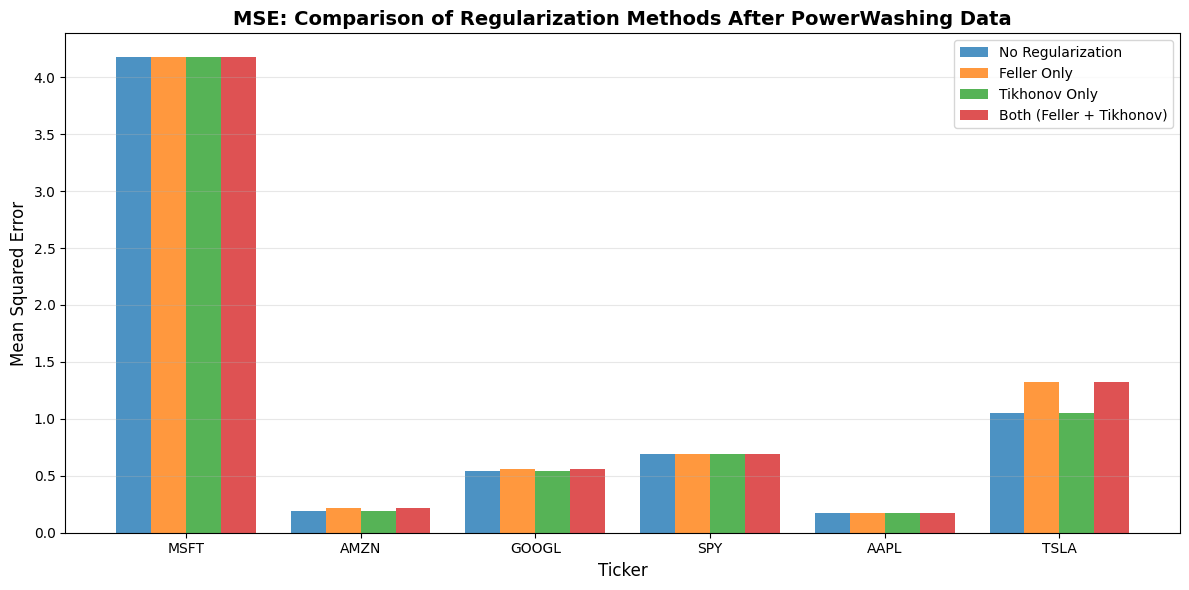

In [45]:

new = []
regular = []
only_feller = []
only_tikhonov = []

for ticker in tickers:
    new_model_prices = price_call(final_models[ticker], new_testing_data[ticker])
    regular_model_prices = price_call(
        final_models_regularized[ticker], new_testing_data[ticker]
    )
    feller_model_prices = price_call(final_models_only_feller[ticker], new_testing_data[ticker])
    tikhonov_model_prices = price_call(
        final_models_only_tikhonov[ticker], new_testing_data[ticker]
    )

    prices = new_testing_data[ticker].market_prices

    new.append(sum((new_model_prices - prices) ** 2) / prices.size)
    regular.append(sum((regular_model_prices - prices) ** 2) / prices.size)
    only_feller.append(sum((feller_model_prices - prices) ** 2) / prices.size)
    only_tikhonov.append(sum((tikhonov_model_prices - prices) ** 2) / prices.size)

x = np.arange(len(tickers))
width = 0.2  # Narrower bars to fit 4 groups

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5 * width, new, width, label="No Regularization", alpha=0.8)
bars2 = ax.bar(x - 0.5 * width, only_feller, width, label="Feller Only", alpha=0.8)
bars3 = ax.bar(x + 0.5 * width, only_tikhonov, width, label="Tikhonov Only", alpha=0.8)
bars4 = ax.bar(
    x + 1.5 * width, regular, width, label="Both (Feller + Tikhonov)", alpha=0.8
)

# Customize the plot
ax.set_xlabel("Ticker", fontsize=12)
ax.set_ylabel("Mean Squared Error", fontsize=12)
ax.set_title(
    "MSE: Comparison of Regularization Methods After PowerWashing Data",
    fontsize=14,
    fontweight="bold",
)
ax.set_xticks(x)
ax.set_xticklabels(tickers)
ax.legend(fontsize=10)
ax.grid(axis="y", alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [37]:



for ticker in tickers:
    ticker_testing = new_testing_data[ticker]
    model_prices = price_call(final_models[ticker], ticker_testing)
    prices = ticker_testing.market_prices

    # Create plot function with proper closure
    plot_fn, abs_errors = create_interactive_plot(ticker, ticker_testing, model_prices, prices)

    interact(
        plot_fn,
        threshold=FloatSlider(
            min=0.01,
            max=float(np.max(abs_errors)),
            step=0.05,
            value=1.0,
            description=f"{ticker} Threshold ($)",
        ),
    )

interactive(children=(FloatSlider(value=1.0, description='MSFT Threshold ($)', max=2.3194418738168707, min=0.0…

interactive(children=(FloatSlider(value=1.0, description='AMZN Threshold ($)', max=1.6147013287153182, min=0.0…

interactive(children=(FloatSlider(value=1.0, description='GOOGL Threshold ($)', max=1.7195745908243723, min=0.…

interactive(children=(FloatSlider(value=1.0, description='SPY Threshold ($)', max=4.44338120164538, min=0.01, …

interactive(children=(FloatSlider(value=1.0, description='AAPL Threshold ($)', max=1.2567983381526133, min=0.0…

interactive(children=(FloatSlider(value=1.0, description='TSLA Threshold ($)', max=2.430135566605202, min=0.01…

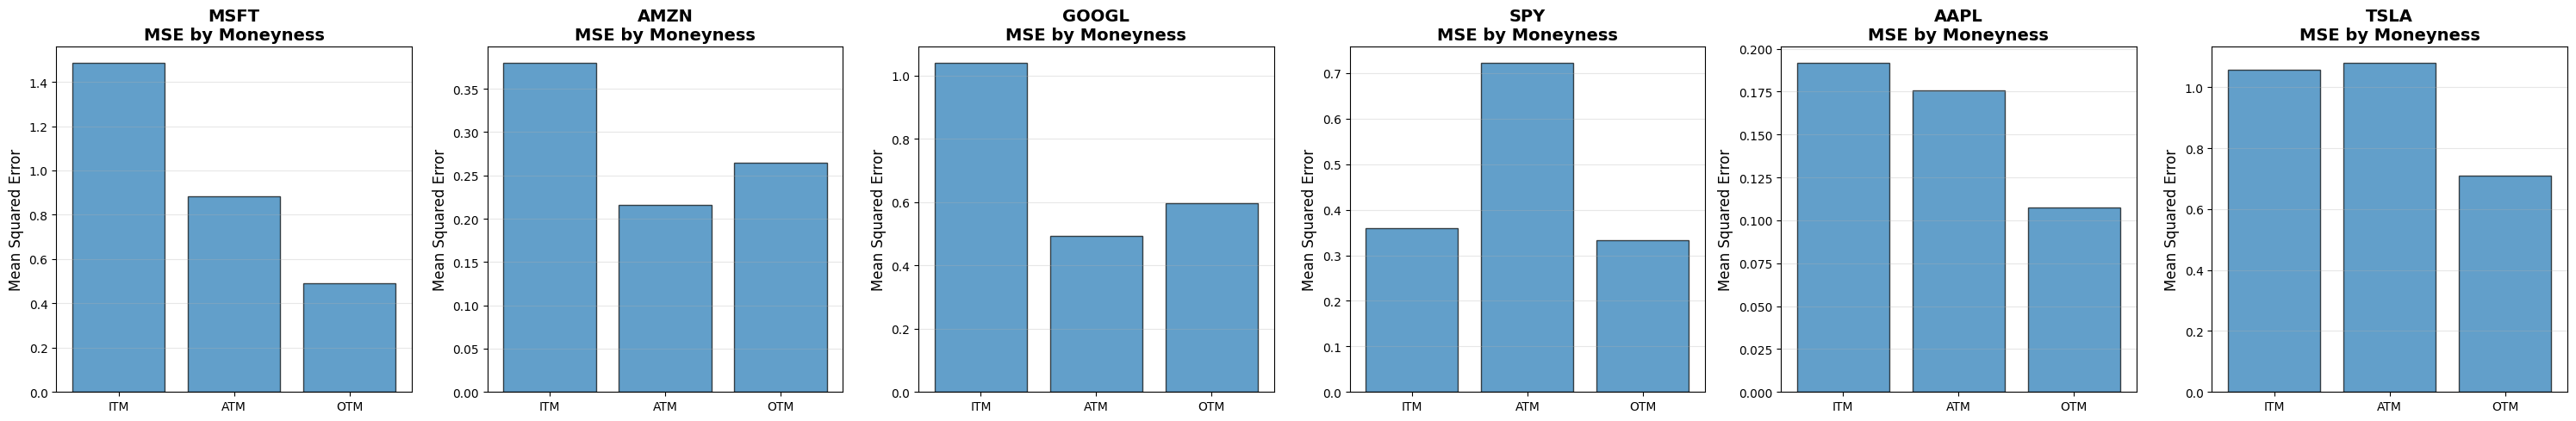

In [38]:
#On Cleaner data, we also get a better sense for when our model has high square error (in terms of moneyness)
# Calculate MSE for each ticker and category
results = {}

for ticker in tickers:
    ticker_testing = new_testing_data[ticker]
    model_prices = price_call(final_models[ticker], ticker_testing)
    market_prices = ticker_testing.market_prices

    # Calculate moneyness variables
    r = ticker_testing.risk_free_rate
    T = ticker_testing.maturities
    S0 = ticker_testing.spot_price
    K = ticker_testing.strikes
    F = S0 * np.exp(r * T)
    x = np.log(F / K)
    c = market_prices * np.exp(r * T)

    # Categorize options
    deep_itm_mask, atm_mask, otm_mask = categorize_options(x, c, F)

    # Calculate MSE for each category
    mse_deep_itm = (
        np.mean((model_prices[deep_itm_mask] - market_prices[deep_itm_mask]) ** 2)
        if np.any(deep_itm_mask)
        else 0
    )
    mse_atm = (
        np.mean((model_prices[atm_mask] - market_prices[atm_mask]) ** 2)
        if np.any(atm_mask)
        else 0
    )
    mse_otm = (
        np.mean((model_prices[otm_mask] - market_prices[otm_mask]) ** 2)
        if np.any(otm_mask)
        else 0
    )

    results[ticker] = {
        "ITM": mse_deep_itm,
        "ATM": mse_atm,
        "OTM": mse_otm,
        "counts": {
            "ITM": np.sum(deep_itm_mask),
            "ATM": np.sum(atm_mask),
            "OTM": np.sum(otm_mask),
        },
    }

# Create bar graphs
fig, axes = plt.subplots(1, len(tickers), figsize=(5 * len(tickers), 5))
if len(tickers) == 1:
    axes = [axes]

categories = ["ITM", "ATM", "OTM"]

for idx, ticker in enumerate(tickers):
    mse_values = [results[ticker][cat] for cat in categories]
    counts = [results[ticker]["counts"][cat] for cat in categories]

    bars = axes[idx].bar(categories, mse_values, alpha=0.7, edgecolor="black")
    axes[idx].set_ylabel("Mean Squared Error", fontsize=12)
    axes[idx].set_title(f"{ticker}\nMSE by Moneyness", fontsize=14, fontweight="bold")
    axes[idx].grid(axis="y", alpha=0.3)


plt.tight_layout()
plt.show()

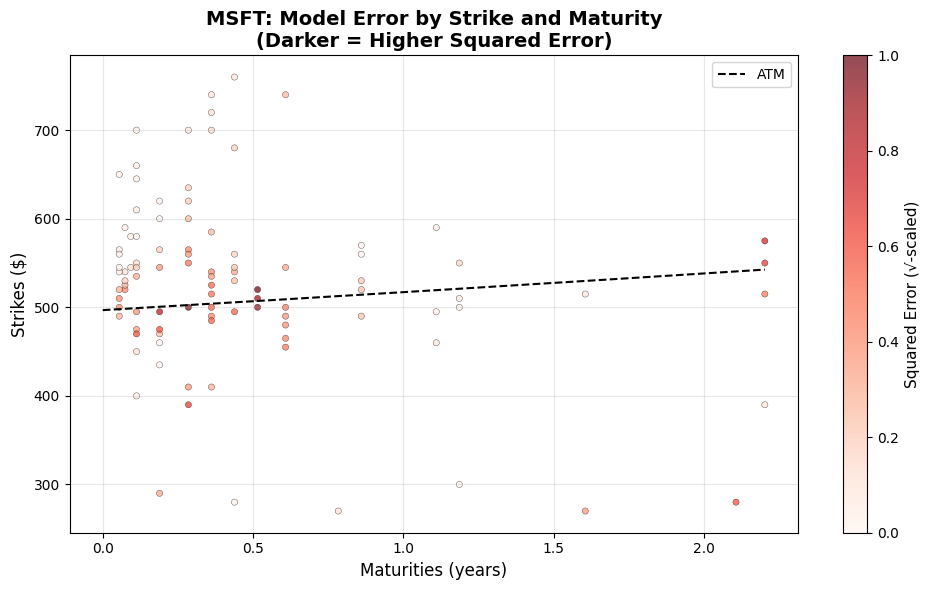

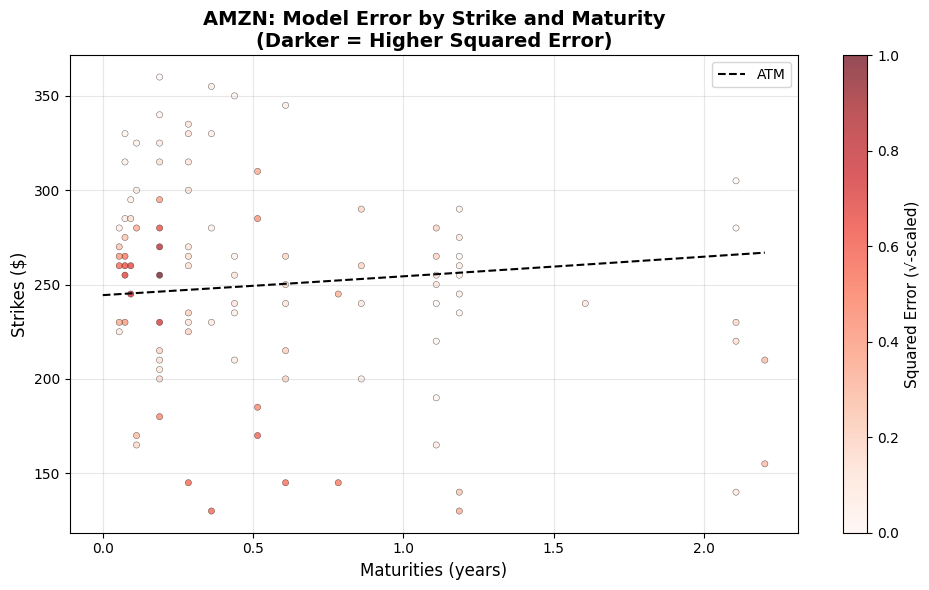

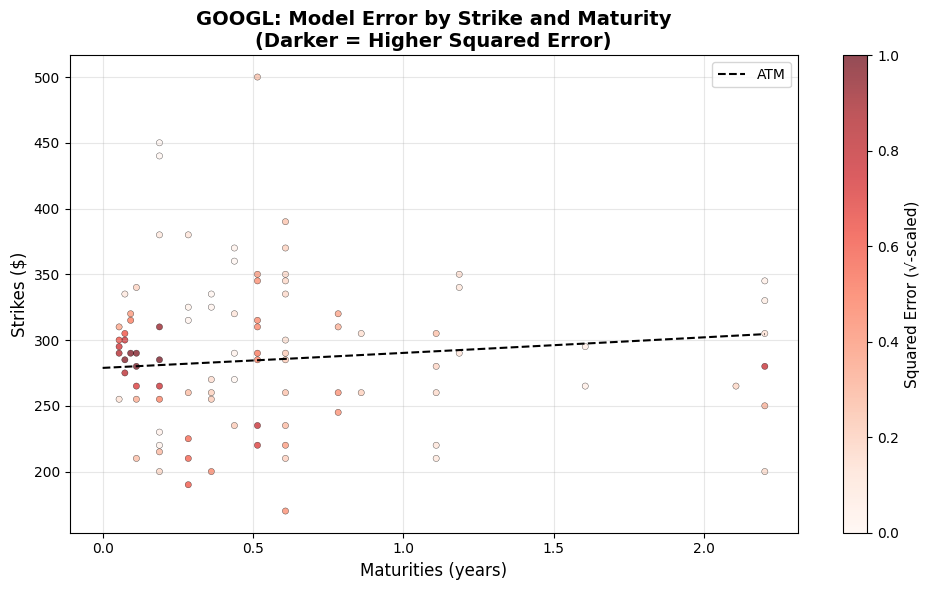

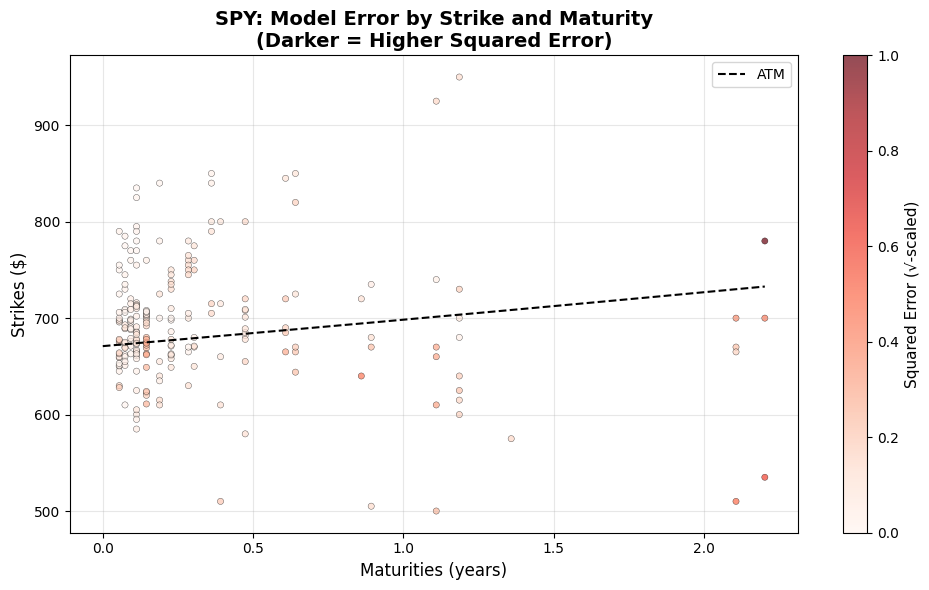

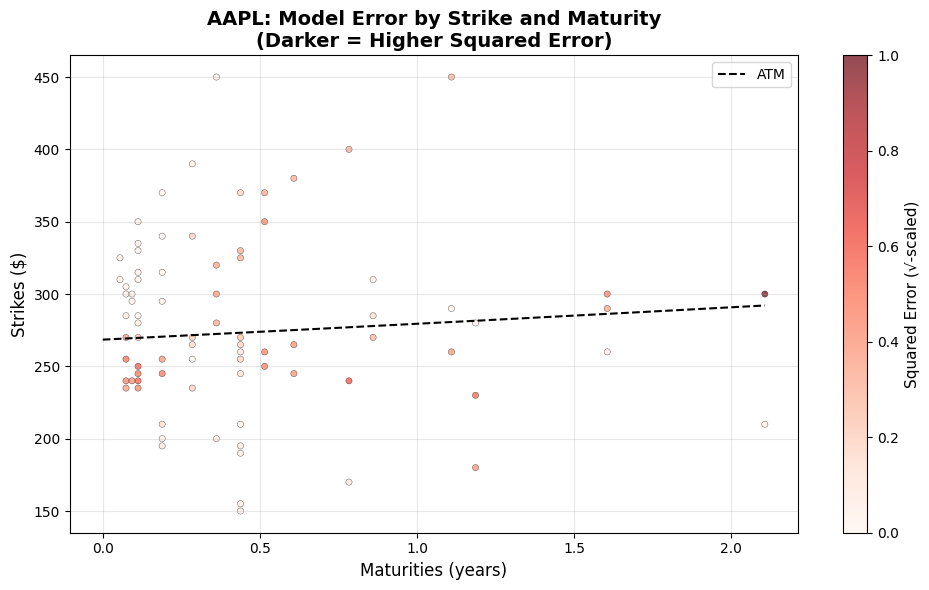

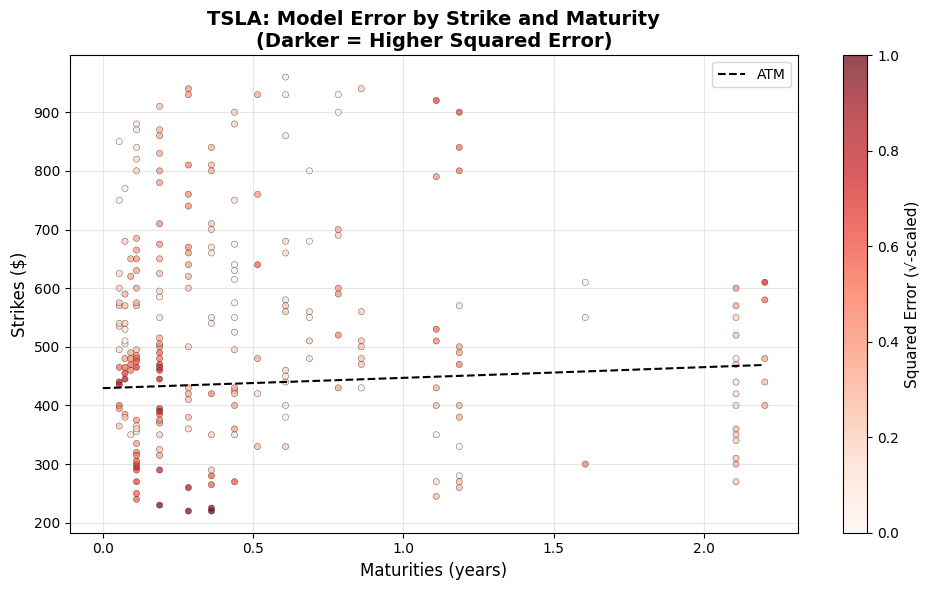

In [39]:
#There is now a much clearer picture for where we apply the Heston Model to options prices that 
# 1. Obey reasonable implied volatility smiles (IV is within 3*initial_volatility)
#2. Do Not violate No Arbitrage Bounds (Most Important.)
#3. Are Monotonic in Strike Price
#4. Are not very deep ITM

# Among Remaining Options, square error is concentrated at Short Term ATM options

for ticker in tickers:
    ticker_testing = new_testing_data[ticker]
    model_prices = price_call(final_models[ticker], ticker_testing)
    prices = ticker_testing.market_prices

    # Calculate squared errors
    squared_errors = (model_prices - prices) ** 2

    # Apply square root transformation to make red appear faster
    if np.max(squared_errors) > 0:
        normalized_errors = np.sqrt(squared_errors / np.max(squared_errors))
    else:
        normalized_errors = squared_errors

    # Plot ATM line
    max_maturity = np.max(ticker_testing.maturities)
    x_function = np.linspace(0, max_maturity, 150)
    r = ticker_testing.risk_free_rate
    y_function = np.exp(r * x_function) * ticker_testing.spot_price

    # Create scatter plot with faster red transition
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(
        ticker_testing.maturities,
        ticker_testing.strikes,
        c=normalized_errors,
        cmap="Reds",
        s=20,
        alpha=0.7,
        vmin=0,
        vmax=1,  # Explicitly set color range
        edgecolors="black",
        linewidth=0.3,
    )

    ax.plot(
        x_function, y_function, color="black", linestyle="--", linewidth=1.5, label="ATM"
    )

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Squared Error (√-scaled)", fontsize=11)

    ax.set_xlabel("Maturities (years)", fontsize=12)
    ax.set_ylabel("Strikes ($)", fontsize=12)
    ax.legend(fontsize=10)
    ax.set_title(
        f"{ticker}: Model Error by Strike and Maturity\n(Darker = Higher Squared Error)",
        fontsize=14,
        fontweight="bold",
    )
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
'''We can also compare paramaters. They are pretty similar! An exception is 'GOOGL' which had a low v_bar and mean reversion rate of ~.01. 
 This demonstrates "local flatness" around parameters, but note that these parameters make the "Reversion to mean"
completely useless:

GOOGLE has a reversion to mean that would take DECADES to become relevant and a mean of 1, which is complete nonsense.
'''

for ticker in tickers:
    print(f"{ticker} model trained before validation: {models[ticker]}")
    print(f"{ticker} final models trained on validated data: {final_models[ticker]}")
    print(f"{ticker} final models regularized and trained on validated data: {final_models_regularized[ticker]}")


MSFT model trained before validation: v0=0.07302938730526715 v_bar=0.07998445812950002 rho=-0.33031856284120614 kappa=1.751378002143689 sigma=0.40321625934560384
MSFT final models trained on validated data: v0=0.06571690756560543 v_bar=0.07567748180048829 rho=-0.3868332724457406 kappa=9.999999999999998 sigma=0.875319560132687
MSFT final models regularized and trained on validated data: v0=0.06571559549582093 v_bar=0.07567714197692597 rho=-0.3868772149208913 kappa=9.999999999999998 sigma=0.8751768511409617
AMZN model trained before validation: v0=0.13761829254747154 v_bar=0.18810473537737113 rho=-0.30271652123520687 kappa=0.6911034761076287 sigma=0.6769273045041498
AMZN final models trained on validated data: v0=0.13677835504800853 v_bar=0.19104042956036563 rho=-0.3068892132559377 kappa=0.6926231913984163 sigma=0.6861004490992709
AMZN final models regularized and trained on validated data: v0=0.136118493449473 v_bar=0.16006285348998775 rho=-0.3614160213197732 kappa=1.120649934265135 sig

In [55]:
new_testing_data['GOOGL'].initial_volatility()

np.float64(0.32417072281934417)

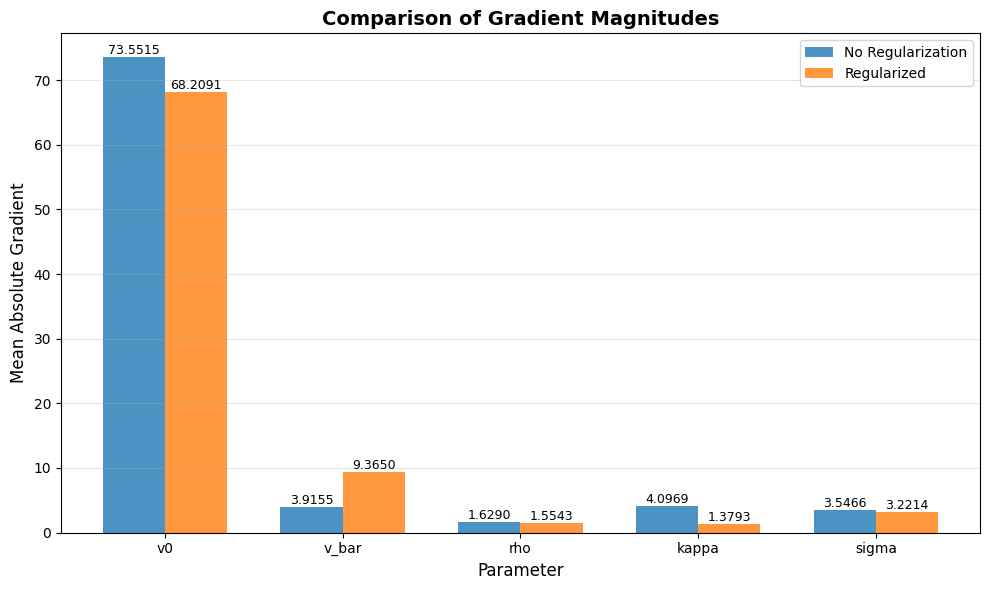

In [ ]:
'''We will try to see if this is true using google as an example. We can check average gradients across market data to see how quickly the 
call prices are changing under slight preturbations of the parameters

'''
def compare_gradient_magnitudes(model1: HestonModel, model2: HestonModel, 
                                market_data: MarketData, 
                                model1_name: str = "Model 1", 
                                model2_name: str = "Model 2"):
    
    S0 = market_data.spot_price
    r = market_data.risk_free_rate
    K = market_data.strikes
    T = market_data.maturities
    
    # Compute gradients for both models
    grad1 = model1._gradient(S0, r, K, T)  # Shape: (5, n_options)
    grad2 = model2._gradient(S0, r, K, T)
    
    # Take mean absolute gradient across all options for each parameter
    mean_abs_grad1 = np.mean(np.abs(grad1), axis=1)
    mean_abs_grad2 = np.mean(np.abs(grad2), axis=1)
    
    # Parameter names
    param_names = ['v0', 'v_bar', 'rho', 'kappa', 'sigma']
    
    # Create bar chart
    x = np.arange(len(param_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, mean_abs_grad1, width, label=model1_name, alpha=0.8)
    bars2 = ax.bar(x + width/2, mean_abs_grad2, width, label=model2_name, alpha=0.8)
    
    # Customize plot
    ax.set_xlabel('Parameter', fontsize=12)
    ax.set_ylabel('Mean Absolute Gradient', fontsize=12)
    ax.set_title('Local Stability: Gradient Magnitudes', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(param_names)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

compare_gradient_magnitudes(final_models['GOOGL'],final_models_regularized['GOOGL'],new_testing_data['GOOGL'],model1_name='No Regularization',model2_name='Regularized')

In [63]:

'''
We can also simulate slight parameter deviations. Note how sensitive the unregularized model is to changes in v_0! This is very bad
'''
def interactive_parameter_sensitivity_comparison(
    model1: HestonModel, 
    model2: HestonModel,
    test_data: MarketData, 
    model1_name: str = "Model 1",
    model2_name: str = "Model 2",
    delta_range=(0.01, 0.1)
):
    """
    Compare parameter sensitivity of two models with side-by-side bars
    """
    # Get base prices for both models
    base_prices1 = price_call(model1, test_data)
    base_prices2 = price_call(model2, test_data)
    
    params = ['v0', 'v_bar', 'rho', 'kappa', 'sigma']
    max_delta = delta_range[1]
    max_mse_values = []
    
    for param in params:
        model_dict = {
            'v0': model1.v0,
            'v_bar': model1.v_bar,
            'rho': model1.rho,
            'kappa': model1.kappa,
            'sigma': model1.sigma
        }
        original_value = model_dict[param]
        model_dict[param] = original_value * (1 + max_delta)
        perturbed_model = HestonModel(**model_dict)
        perturbed_prices = price_call(perturbed_model, test_data)
        mse = np.mean(np.abs(perturbed_prices - base_prices1))
        max_mse_values.append(mse)
    
    for param in params:
        model_dict = {
            'v0': model2.v0,
            'v_bar': model2.v_bar,
            'rho': model2.rho,
            'kappa': model2.kappa,
            'sigma': model2.sigma
        }
        original_value = model_dict[param]
        model_dict[param] = original_value * (1 + max_delta)
        perturbed_model = HestonModel(**model_dict)
        perturbed_prices = price_call(perturbed_model, test_data)
        mse = np.mean((perturbed_prices - base_prices2)**2)
        max_mse_values.append(mse)
    
    # Set static y-axis limit
    static_y_max = max(max_mse_values)
    
    def plot_sensitivity(delta):
        mse_values1 = []
        mse_values2 = []
        
        for param in params:
            model_dict = {
                'v0': model1.v0,
                'v_bar': model1.v_bar,
                'rho': model1.rho,
                'kappa': model1.kappa,
                'sigma': model1.sigma
            }
            original_value = model_dict[param]
            model_dict[param] = original_value * (1 + delta)
            perturbed_model = HestonModel(**model_dict)
            perturbed_prices = price_call(perturbed_model, test_data)
            mse = np.mean((perturbed_prices - base_prices1)**2)
            mse_values1.append(mse)
        
        for param in params:
            model_dict = {
                'v0': model2.v0,
                'v_bar': model2.v_bar,
                'rho': model2.rho,
                'kappa': model2.kappa,
                'sigma': model2.sigma
            }
            original_value = model_dict[param]
            model_dict[param] = original_value * (1 + delta)
            perturbed_model = HestonModel(**model_dict)
            perturbed_prices = price_call(perturbed_model, test_data)
            mse = np.mean((perturbed_prices - base_prices2)**2)
            mse_values2.append(mse)
        
        # Create single bar chart with side-by-side bars
        x = np.arange(len(params))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(12, 7))
        
        bars1 = ax.bar(x - width/2, mse_values1, width, label=model1_name, 
                      alpha=0.8, edgecolor='black', linewidth=1)
        bars2 = ax.bar(x + width/2, mse_values2, width, label=model2_name, 
                      alpha=0.8, edgecolor='black', linewidth=1)
        
        ax.set_xlabel('Parameter', fontsize=12)
        ax.set_ylabel('Mean Square Error in Price ($)', fontsize=12)
        ax.set_title(f'Local Parameter Sensitivity Comparison (δ = {delta*100:.2f}%)\nMSE when parameter increased by {delta*100:.2f}%', 
                     fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(params)
        ax.legend(fontsize=11)
        ax.grid(axis='y', alpha=0.3)
        
        # Set static y-axis
        ax.set_ylim(0, static_y_max)
        
        # Add value labels on bars
        for bar, mse in zip(bars1, mse_values1):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'${mse:.4f}',
                   ha='center', va='bottom', fontsize=9)
        
        for bar, mse in zip(bars2, mse_values2):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'${mse:.4f}',
                   ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        
       
    
    # Create interactive widget
    interact(plot_sensitivity,
             delta=FloatSlider(
                 min=delta_range[0],
                 max=delta_range[1],
                 step=0.001,
                 value=0.01,
                 description='Delta (δ)',
                 style={'description_width': 'initial'},
                 continuous_update=False
             ))

interactive_parameter_sensitivity_comparison(
    final_models_regularized['GOOGL'],
    final_models['GOOGL'],
    new_testing_data['GOOGL'],
    model1_name='Regularized',
    model2_name='Not Regularized'
)




/Users/bubba/Documents/python notebooks/finance bootcamp /heston_project/heston.py:37: UserWarning: Feller condition not satisfied
  warnings.warn('Feller condition not satisfied')


interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='Delta (δ)', max=0.1, min=0…

Economic Implications of Parameter Values:

  v_bar = 1.0000
    → Long-run volatility = 100.0%
    → This is EXTREME (typical stocks: 15-40%)
    → Model expects perpetual crisis-level volatility

  kappa = 0.0134
    → Mean reversion half-life = 51.8 years
    → Volatility takes 52 years to revert halfway
    → This is essentially NO mean reversion
    → Contradicts empirical evidence (typical: 0.5-3 years)

Impact on Option Pricing:
  At T=0.25y: E[v_T] = 0.1502 (38.8% vol)
  At T=0.50y: E[v_T] = 0.1530 (39.1% vol)
  At T=1.00y: E[v_T] = 0.1587 (39.8% vol)
  At T=2.00y: E[v_T] = 0.1699 (41.2% vol)
  At T=5.00y: E[v_T] = 0.2025 (45.0% vol)

→ With kappa≈0, variance barely changes with maturity
→ This produces nearly FLAT term structure (unrealistic)


MSFT
Removed 5 / 462 options (1.1%)
  - Lower bound violations: 5
  - Upper bound violations: 0
  - Monotonicity violations: 0
AMZN
Removed 0 / 439 options (0.0%)
  - Lower bound violations: 0
  - Upper bound violations: 0
  - Monotonicity violations: 0
GOOGL
Removed 9 / 413 options (2.2%)
  - Lower bound violations: 8
  - Upper bound violations: 0
  - Monotonicity violations: 1
SPY
Removed 90 / 1109 options (8.1%)
  - Lower bound violations: 89
  - Upper bound violations: 0
  - Monotonicity violations: 1
AAPL
Removed 28 / 427 options (6.6%)
  - Lower bound violations: 28
  - Upper bound violations: 0
  - Monotonicity violations: 0
TSLA
Removed 0 / 1003 options (0.0%)
  - Lower bound violations: 0
  - Upper bound violations: 0
  - Monotonicity violations: 0


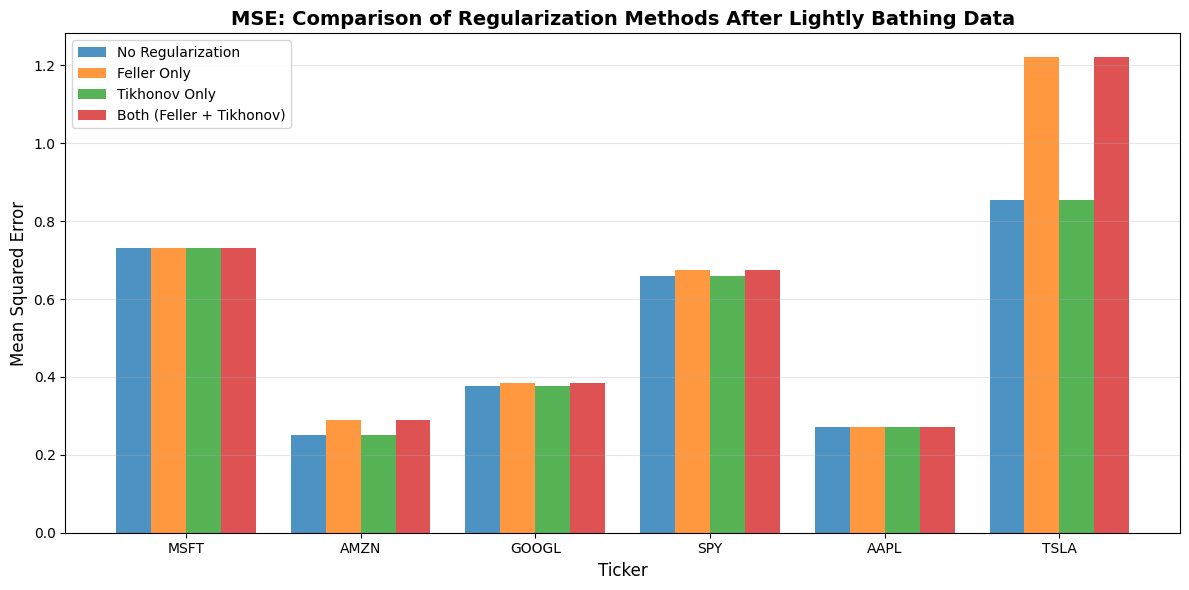

In [43]:
#For quick calibration of very volatile stocks, we can also leave out the volatility smile requirements in our data for trading and validation.
#Simply excluding arbitrage bounds and imposing (fairly weak) monotonicity (anectdotally) already produces significantly better results
#than doing nothing.
sensible_data={}
insensible_data={}
for ticker in tickers:
    print(ticker)
    sensible_data[ticker],insensible_data[ticker]=validate_option_data(cleaned_data[ticker],check_iv=False,check_monotonicity=True,return_outliers=True)

final_models = {}
final_models_regularized = {}
final_models_only_feller = {}
final_models_only_tikhonov = {}

for ticker in tickers:
    
    new_training_data[ticker], new_testing_data[ticker] = sensible_data[ticker].testing()


for ticker in tickers:
    final_models[ticker] = calibrate_regularized(
        new_training_data[ticker], lambda_feller=0, lambda_tikhonov=0
    )
    final_models_regularized[ticker] = calibrate_regularized(new_training_data[ticker])
    final_models_only_feller[ticker] = calibrate_regularized(
        new_training_data[ticker], lambda_tikhonov=0
    )
    final_models_only_tikhonov[ticker] = calibrate_regularized(
        new_training_data[ticker], lambda_feller=0
    )


new = []
regular = []
only_feller = []
only_tikhonov = []

for ticker in tickers:
    new_model_prices = price_call(final_models[ticker], new_testing_data[ticker])
    regular_model_prices = price_call(
        final_models_regularized[ticker], new_testing_data[ticker]
    )
    feller_model_prices = price_call(final_models_only_feller[ticker], new_testing_data[ticker])
    tikhonov_model_prices = price_call(
        final_models_only_tikhonov[ticker], new_testing_data[ticker]
    )

    prices = new_testing_data[ticker].market_prices

    new.append(sum((new_model_prices - prices) ** 2) / prices.size)
    regular.append(sum((regular_model_prices - prices) ** 2) / prices.size)
    only_feller.append(sum((feller_model_prices - prices) ** 2) / prices.size)
    only_tikhonov.append(sum((tikhonov_model_prices - prices) ** 2) / prices.size)

x = np.arange(len(tickers))
width = 0.2  # Narrower bars to fit 4 groups

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5 * width, new, width, label="No Regularization", alpha=0.8)
bars2 = ax.bar(x - 0.5 * width, only_feller, width, label="Feller Only", alpha=0.8)
bars3 = ax.bar(x + 0.5 * width, only_tikhonov, width, label="Tikhonov Only", alpha=0.8)
bars4 = ax.bar(
    x + 1.5 * width, regular, width, label="Both (Feller + Tikhonov)", alpha=0.8
)

# Customize the plot
ax.set_xlabel("Ticker", fontsize=12)
ax.set_ylabel("Mean Squared Error", fontsize=12)
ax.set_title(
    "MSE: Comparison of Regularization Methods After Lightly Bathing Data",
    fontsize=14,
    fontweight="bold",
)
ax.set_xticks(x)
ax.set_xticklabels(tickers)
ax.legend(fontsize=10)
ax.grid(axis="y", alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()